In [51]:
import os
# os.chdir("/users/sven/Documents/code/threepoint/python_scripts/")

# from file_loader import get_kappa_millennium
# from compute_aperture_mass import aperture_mass_computer
import numpy as np
import sys
import multiprocessing as mp
from itertools import permutations
import os
# from astropy.convolution import convolve_fft
from scipy import ndimage
from scipy.signal import fftconvolve,correlate
from astropy.io import fits
import warnings


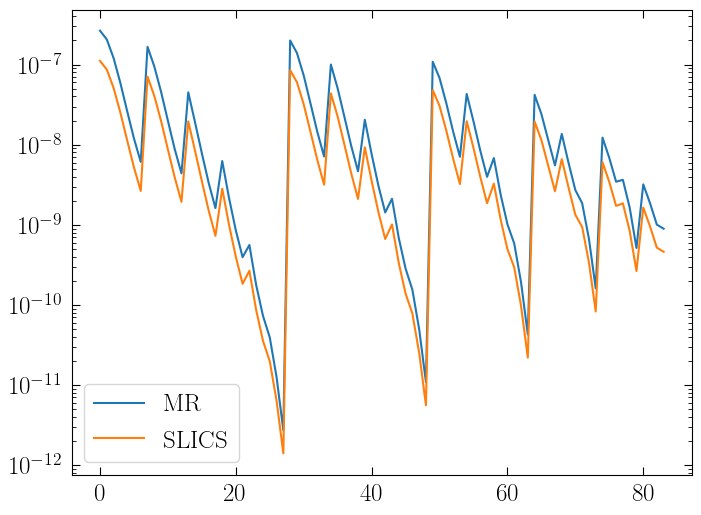

In [89]:
msmap3 = np.loadtxt("/users/sven/Documents/code/results_MR/MapMapMap_0p5_to_32.dat")[:,-1]
slicsmap3 = np.loadtxt("/users/sven/Documents/code/results_SLICS/MapMapMap_0p5_to_32.dat")[:,-1]

plt.plot(msmap3,label='MR')
plt.plot(slicsmap3,label='SLICS')
plt.legend()
plt.yscale('log')
plt.show()

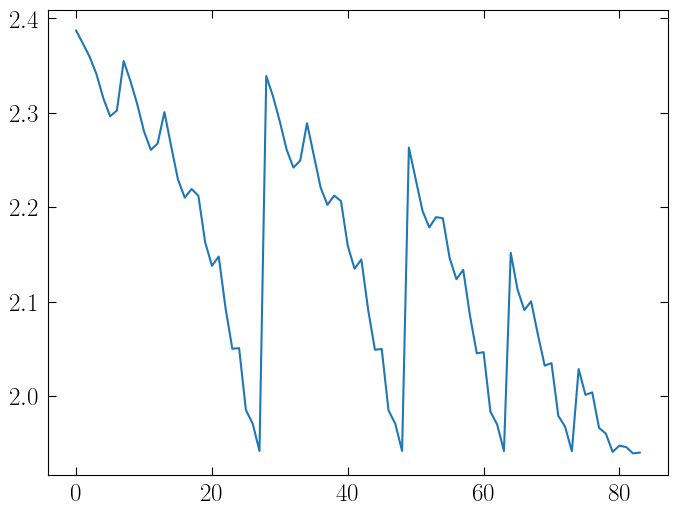

In [90]:
plt.plot(msmap3/slicsmap3)
plt.show()

In [52]:
def get_SLICS(los,filepath = "/vol/euclid2/euclid2_raid2/sven/HOWLS/shear_catalogues/SLICS_LCDM/",
    filenotfound="warn"):
    # fieldsize = 600.
    # npix = 4096
    if(filenotfound=="error"):
        field = fits.open(filepath+"GalCatalog_LOS_cone{}.fits_s333{}_zmin0.0_zmax3.0_sys_3.fits".format(los,los))
    else:
        try:
            field = fits.open(filepath+"GalCatalog_LOS_cone{}.fits_s333{}_zmin0.0_zmax3.0_sys_3.fits".format(los,los))
        except Exception as e:
            if(filenotfound=="warn"):
                warnings.warn("Error loading file for los {}: {}".format(los,e))
            return -1

    data = field[1].data

    X_pos = data['ra_gal']*60.
    Y_pos = data['dec_gal']*60.
    shear_noise = -1.*data['gamma1_noise']+1.0j*data['gamma2_noise']
    return X_pos,Y_pos,shear_noise


In [53]:
def get_one_mapmapmap_treecorr(los,
                    fpath = "/vol/euclid2/euclid2_raid2/sven/mapCorr_SLICS_for_T4_new/"):
    ac = aperture_mass_computer(4096,2,10.*60)
    theta_ap_array = [2,4,8,16]
    myfield = get_SLICS(los,filenotfound="warn")
    if(myfield==-1):
        return
    X_pos,Y_pos,shear_catalogue = myfield
    shears,norm = ac.normalize_shear(X_pos,Y_pos,shear_catalogue)


    idx_cut = int(round(4.*16 * 4096 / (10.*60)))
    cut_fieldsize = 10.*(4096-2*idx_cut)/4096
    fields = np.zeros((len(theta_ap_array),4096-2*idx_cut,4096-2*idx_cut))
    n_theta = len(theta_ap_array)
    for x,theta_ap in enumerate(theta_ap_array):
        ac.change_theta_ap(theta_ap)
        field = ac.Map_fft(shears,norm=norm,return_mcross=False,periodic_boundary=False)
        cut_field = field[idx_cut:-idx_cut,idx_cut:-idx_cut]
        fields[x] = cut_field
    print("Map calculation for los {} done. Resuming with T1!".format(los))
    return fields


In [140]:
fields = get_one_mapmapmap_treecorr(74)

Map calculation for los 74 done. Resuming with T1!


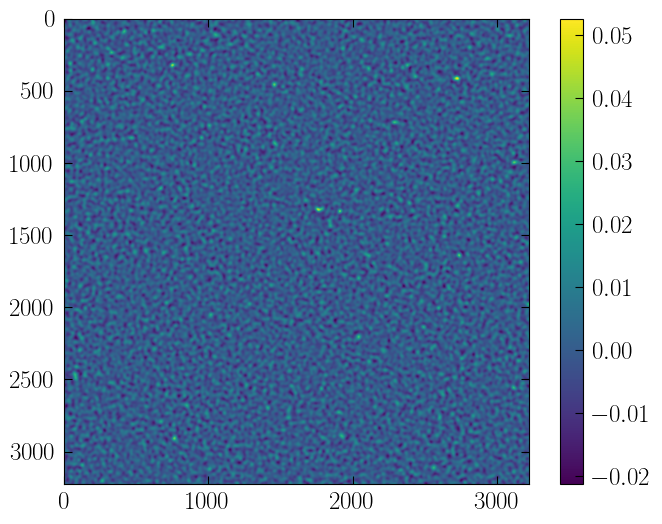

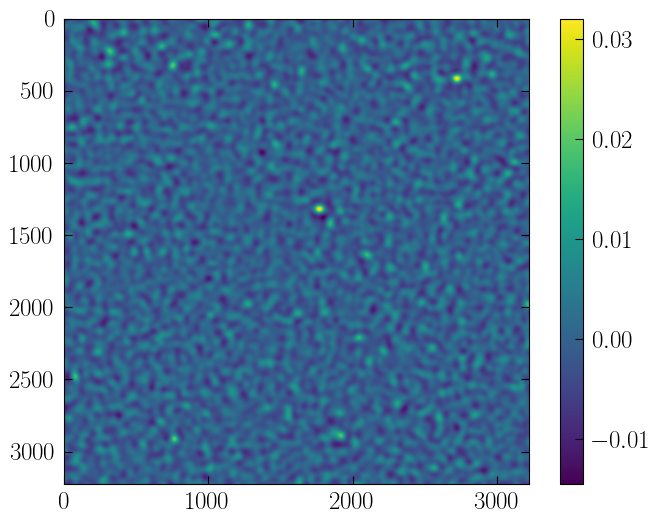

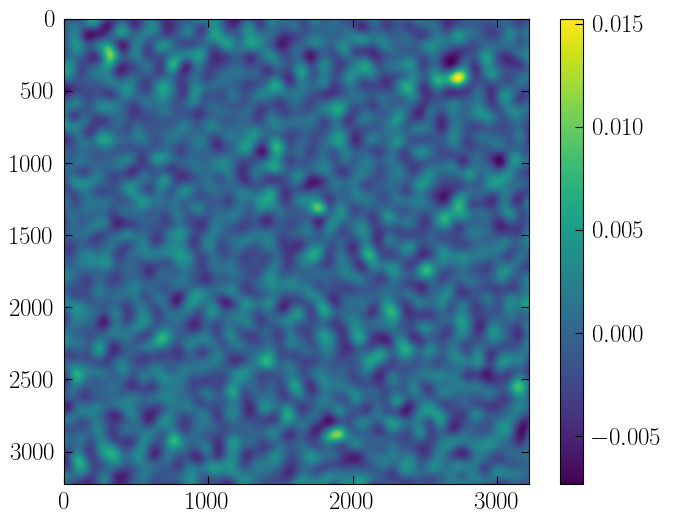

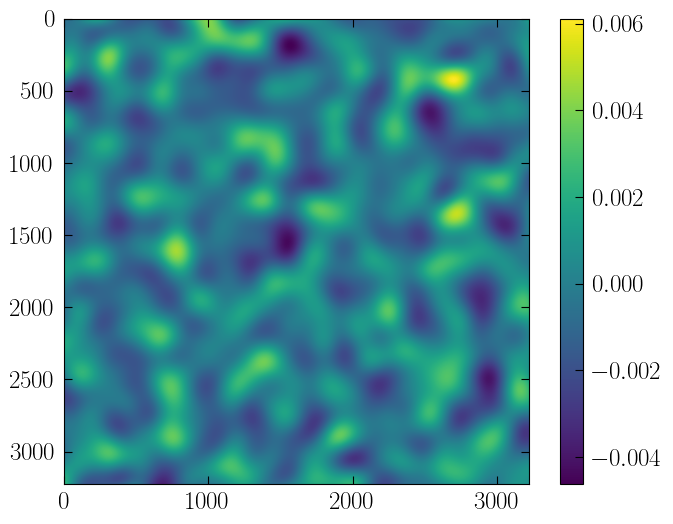

In [141]:
for x in range(4):
    plt.imshow(fields[x])
    plt.colorbar()
    plt.show()

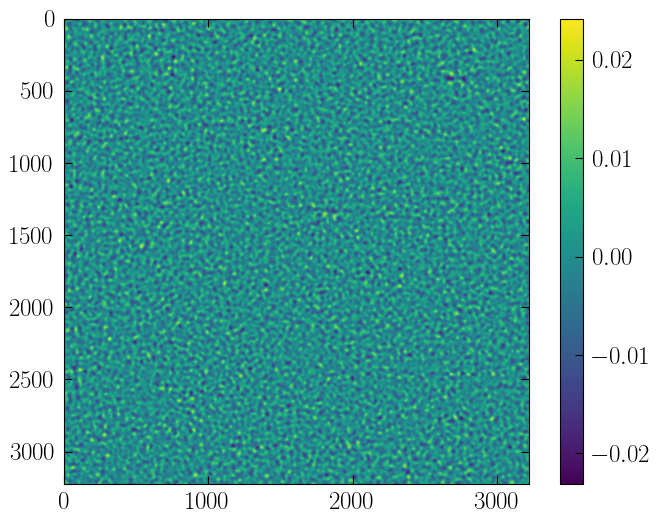

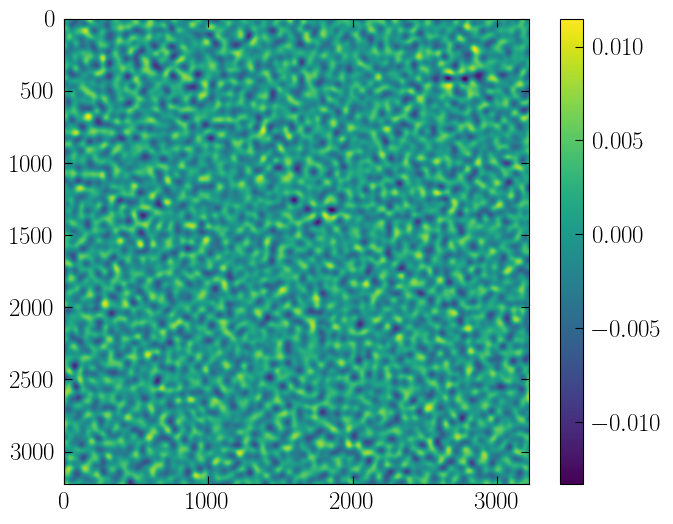

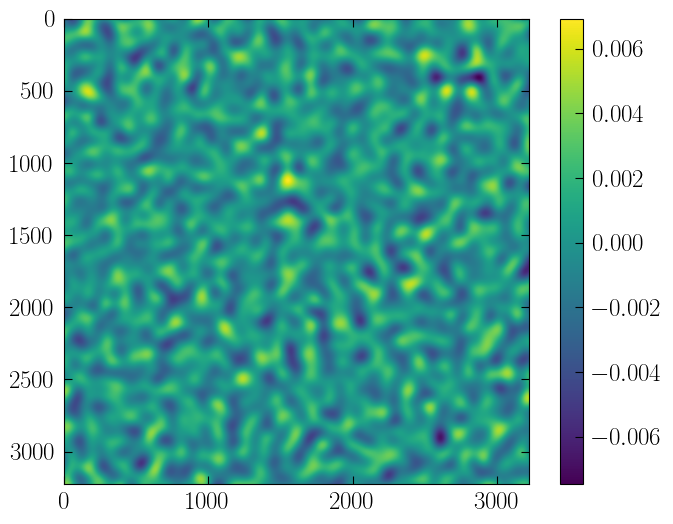

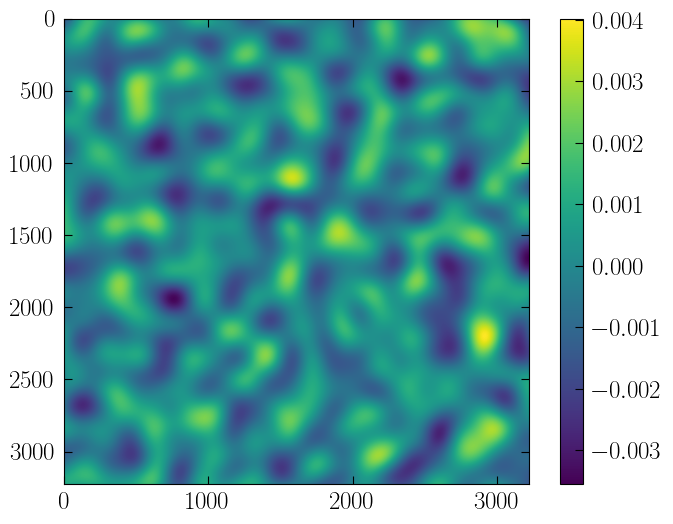

In [59]:
for x in range(4):
    plt.imshow(fields[x])
    plt.colorbar()
    plt.show()

In [54]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.integrate import quad,trapz
# import treecorr
from itertools import permutations
from tqdm.notebook import tqdm,trange
import sys
from matplotlib import colors
from math import log as mlog


In [55]:
plt.rcParams['figure.figsize']        = 8., 6.
plt.rcParams['figure.dpi']            = 100
plt.rcParams['figure.subplot.left']   = 0.125
plt.rcParams['figure.subplot.right']  = 0.9
plt.rcParams['figure.subplot.bottom'] = 0.125
plt.rcParams['figure.subplot.top']    = 0.9
plt.rcParams['axes.labelsize']        = 18
plt.rcParams['axes.titlesize']        = 18
plt.rcParams['xtick.top']             = True
plt.rcParams['xtick.bottom']          = True
plt.rcParams['ytick.left']            = True
plt.rcParams['ytick.right']           = True
plt.rcParams['xtick.direction']       = 'in'
plt.rcParams['ytick.direction']       = 'in'
plt.rcParams['xtick.labelsize']       = 18
plt.rcParams['ytick.labelsize']       = 18
plt.rcParams['xtick.major.pad']       = 6.
plt.rcParams['xtick.minor.pad']       = 6.
plt.rcParams['ytick.major.pad']       = 6.
plt.rcParams['ytick.minor.pad']       = 6.
plt.rcParams['xtick.major.size']      = 6. # major tick size in points
plt.rcParams['xtick.minor.size']      = 3. # minor tick size in points
plt.rcParams['ytick.major.size']      = 6. # major tick size in points
plt.rcParams['ytick.minor.size']      = 3. # minor tick size in points
plt.rcParams['text.usetex']           = True
plt.rcParams['font.family']           = 'serif'
#plt.rcParams['font.serif']            = 'Computer Modern Roman Bold'
plt.rcParams['font.size']             = 18


In [56]:
def progressBar(name, value, endvalue, bar_length = 25, width = 20):
    """
    Displays a progress bar with "name", tracking the progess of value/endvalue
    """
    percent = float(value) / endvalue
    arrow = '-' * int(round(percent*bar_length) - 1) + '>'
    spaces = ' ' * (bar_length - len(arrow))
    sys.stdout.write("\r{0: <{1}} : [{2}]{3}%".format(name, width, arrow + spaces, int(round(percent*100))))
    sys.stdout.flush()
    if value == endvalue:
         sys.stdout.write('\n\n')


def Efunction(theta,L=60.):
    theta = theta/L
    if(hasattr(theta,"__len__")):
        result = np.zeros_like(theta)
        result[(theta<=1)] = (np.pi+ (theta[(theta<=1)]-4)*theta[(theta<=1)])/np.pi
        result[(theta>1)] = (2*((-1) + 2*np.sqrt(1 - theta[(theta>1)]**(-2))*theta[(theta>1)] \
                                - (theta[(theta>1)]**2)/2 - np.arccos(theta[(theta>1)]**(-1)) \
                                + np.arcsin(theta[(theta>1)]**(-1))))/np.pi
        result[(theta>=np.sqrt(2))] = 0
    else:
        if(theta<=1):
            result = (np.pi+ (theta-4)*theta)/np.pi
        if(theta>1):
            result = (2*((-1) + 2*np.sqrt(1 - theta**(-2))*theta \
                                - (theta**2)/2 - np.arccos(theta**(-1)) \
                                + np.arcsin(theta**(-1))))/np.pi
        if(theta>=np.sqrt(2)):
            result = 0
    return result


# MS covariances

In [57]:
all_los = np.arange(64)
all_los_T7 = np.arange(64)

all_theta_ap = [2,4,8,16]

n_los = len(all_los)
n_los_T7 = len(all_los_T7)

n_theta_ap = len(all_theta_ap)
n_theta = 2000-1

results_map_map = np.zeros((n_los,n_theta_ap,n_theta_ap,n_theta))
results_mapsq_map = np.zeros((n_los,n_theta_ap,n_theta_ap,n_theta_ap,n_theta))
results_map_mapcu = np.zeros((n_los_T7,n_theta_ap,n_theta_ap,n_theta_ap,n_theta_ap,n_theta))
results_mapsq_mapsq = np.zeros((n_los,n_theta_ap,n_theta_ap,n_theta_ap,n_theta_ap,n_theta))
results_mapcu_mapcu = np.zeros((n_los,n_theta_ap,n_theta_ap,n_theta_ap,n_theta_ap,n_theta_ap,n_theta_ap,n_theta))
mean_thetas = np.zeros(n_theta)



fpath = "/vol/euclid2/euclid2_raid2/sven/mapCorr_for_T4/"


map_squared = np.zeros((n_los,n_theta_ap,n_theta_ap))
map_cubed = np.zeros((n_los,n_theta_ap,n_theta_ap,n_theta_ap))
map_four = np.zeros((n_los,n_theta_ap,n_theta_ap,n_theta_ap,n_theta_ap))
map_six = np.zeros((n_los,n_theta_ap,n_theta_ap,n_theta_ap,n_theta_ap,n_theta_ap,n_theta_ap))

for los in tqdm(all_los,desc="Reading map powers"):
    map_squared[los] = np.load(fpath+"map_squared_los_{}.npy".format(los))
    map_cubed[los] = np.load(fpath+"map_cubed_los_{}.npy".format(los))
    map_four[los] = np.load(fpath+"map_four_los_{}.npy".format(los))
    map_six[los] = np.load(fpath+"map_six_los_{}.npy".format(los))

map_squared_mean = np.mean(map_squared,axis=0)
map_cubed_mean = np.mean(map_cubed,axis=0)
map_four_mean = np.mean(map_four,axis=0)
map_six_mean = np.mean(map_six,axis=0)


for los in tqdm(all_los,desc="Reading map map"):
    for i in range(n_theta_ap):
        for j in range(i,n_theta_ap):
            gg = np.load(fpath+"ggcorr_map_{}_map_{}_los_{}.npy".format(all_theta_ap[i],all_theta_ap[j],los))
            results_map_map[los,i,j] = gg[1,:-1]
            results_map_map[los,j,i] = gg[1,:-1]
   

for los in tqdm(all_los,desc="Reading mapsq map"):
    for i in range(n_theta_ap):
        for j in range(i,n_theta_ap):
            for k in range(n_theta_ap):
                gg = np.load(fpath+"ggcorr_mapsq_{}_{}_map_{}_los_{}.npy".format(all_theta_ap[i],all_theta_ap[j],
                                                                         all_theta_ap[k],los))
                results_mapsq_map[los,i,j,k] = gg[1,:-1]
                results_mapsq_map[los,j,i,k] = gg[1,:-1]
    

for los in tqdm(all_los_T7,desc="Reading map mapcu"):
    for i in range(n_theta_ap):
        for j in range(i,n_theta_ap):
            for k in range(j,n_theta_ap):
                for ii in range(n_theta_ap):
                    gg = np.load(fpath+"ggcorr_map_{}_mapcu_{}_{}_{}_los_{}.npy".format(all_theta_ap[ii],
                                                                                   all_theta_ap[i],
                                                                                   all_theta_ap[j],
                                                                             all_theta_ap[k],los))
                    for idi,idj,idk in permutations([i,j,k]):
                        results_map_mapcu[los,ii,idi,idj,idk] = gg[1,:-1]

    
for los in tqdm(all_los,desc="Reading mapsq mapsq"):
    for i in range(n_theta_ap):
        for j in range(i,n_theta_ap):
            for ii in range(n_theta_ap):
                for jj in range(ii,n_theta_ap):
                    gg = np.load(fpath+"ggcorr_mapsq_{}_{}_mapsq_{}_{}_los_{}.npy".format(all_theta_ap[i],
                                                    all_theta_ap[j],
                                                    all_theta_ap[ii],
                                                    all_theta_ap[jj],
                                                    los))
                    for idi,idj in permutations([i,j]):
                        for idii,idjj in permutations([ii,jj]):
                            results_mapsq_mapsq[los,idi,idj,idii,idjj] = gg[1,:-1]


for los in tqdm(all_los,desc="Reading mapcu mapcu"):
    for i in range(n_theta_ap):
        for j in range(i,n_theta_ap):
            for k in range(j,n_theta_ap):
                for ii in range(n_theta_ap):
                    for jj in range(ii,n_theta_ap):
                        for kk in range(jj,n_theta_ap):
                            gg = np.load(fpath+"ggcorr_mapcu_{}_{}_{}_mapcu_{}_{}_{}_los_{}.npy".format(all_theta_ap[i],
                                                            all_theta_ap[j],
                                                            all_theta_ap[k],
                                                            all_theta_ap[ii],
                                                            all_theta_ap[jj],
                                                            all_theta_ap[kk],
                                                            los))
                            for idi,idj,idk in permutations([i,j,k]):
                                for idii,idjj,idkk in permutations([ii,jj,kk]):
                                    results_mapcu_mapcu[los,idi,idj,idk,idii,idjj,idkk] = gg[1,:-1]
        

_thetas_mean = mean_thetas
_results_mapsq_map_mean = np.mean(results_mapsq_map,axis=0)
_results_map_mapcu_mean = np.mean(results_map_mapcu,axis=0)

_results_mapsq_mapsq_mean = np.mean(results_mapsq_mapsq,axis=0)

_results_map_map_mean = np.mean(results_map_map,axis=0)
_results_mapcu_mapcu_mean = np.mean(results_mapcu_mapcu,axis=0)




In [85]:
map_single = np.zeros((n_los,n_theta_ap))

for los in tqdm(all_los,desc="Reading map powers"):
    map_single[los] = np.load(fpath+"map_single_los_{}.npy".format(los))
    
map_single_mean = np.mean(map_single,axis=0)


In [86]:
mean_thetas = np.load("/vol/euclid2/euclid2_raid2/sven/mapCorr_for_T4/theta_bins.npy")[:-1]

In [87]:
thetas_mean = np.insert(mean_thetas,0,0)/180*np.pi
results_mapsq_map_mean = np.insert(_results_mapsq_map_mean,0,map_cubed_mean,axis=-1)
results_map_mapcu_mean = np.insert(_results_map_mapcu_mean,0,map_four_mean,axis=-1)
results_mapsq_mapsq_mean = np.insert(_results_mapsq_mapsq_mean,0,map_four_mean,axis=-1)
results_map_map_mean = np.insert(_results_map_map_mean,0,map_squared_mean,axis=-1)
results_mapcu_mapcu_mean = np.insert(_results_mapcu_mapcu_mean,0,map_six_mean,axis=-1)


full_results_mapsq_map = np.insert(results_mapsq_map,0,map_cubed_mean,axis=-1)
full_results_map_mapcu = np.insert(results_map_mapcu,0,map_four_mean,axis=-1)
full_results_mapsq_mapsq = np.insert(results_mapsq_mapsq,0,map_four_mean,axis=-1)
full_results_map_map = np.insert(results_map_map,0,map_squared_mean,axis=-1)
full_results_mapcu_mapcu = np.insert(results_mapcu_mapcu,0,map_six_mean,axis=-1)


In [88]:
np.any(results_mapsq_mapsq==0)

False

In [89]:
map_four_mean.shape

(4, 4, 4, 4)

Text(0.5, 0, '$\\eta$ [arcmin]')

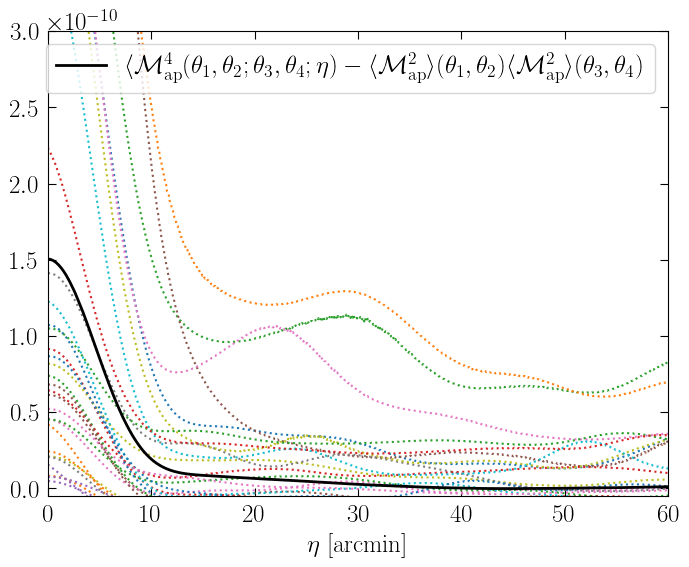

In [90]:
for i in range(35):
    plt.plot(thetas_mean[:1999]*180/np.pi*60,
#              Efunction(thetas_mean[:1999],L)*thetas_mean[:1999]*
             results_mapsq_mapsq[i,1,1,2,2,:1999]-(map_squared_mean[1,1]*map_squared_mean[2,2]),
             linestyle=':')
plt.plot(thetas_mean[:1999]*180/np.pi*60,
#          Efunction(thetas_mean[:1999],L)*thetas_mean[:1999]*
         _results_mapsq_mapsq_mean[1,1,2,2,:1999]-(map_squared_mean[1,1]*map_squared_mean[2,2]),
         linewidth=2,color='black',label=r"$\langle\mathcal{M}_\mathrm{ap}^4(\theta_1,\theta_2;\theta_3,\theta_4;\eta)-\langle\mathcal{M}_\mathrm{ap}^2\rangle(\theta_1,\theta_2)\langle\mathcal{M}_\mathrm{ap}^2\rangle(\theta_3,\theta_4)$")

plt.legend()
plt.ylim(-0.05*10**-10,3*10**-10)
plt.xlim(0,60)
plt.xlabel(r"$\eta$ [arcmin]")
# plt.yscale("log")
# plt.plot(0,map_squared_mean[0,0],marker='o',color='black')
# plt.xlim(-0.1,1)
# plt.plot(thetas_mean[:500],Efunction(thetas_mean[:500],L)/10**4.5,color='red')

Text(0.5, 0, '$\\eta$ [arcmin]')

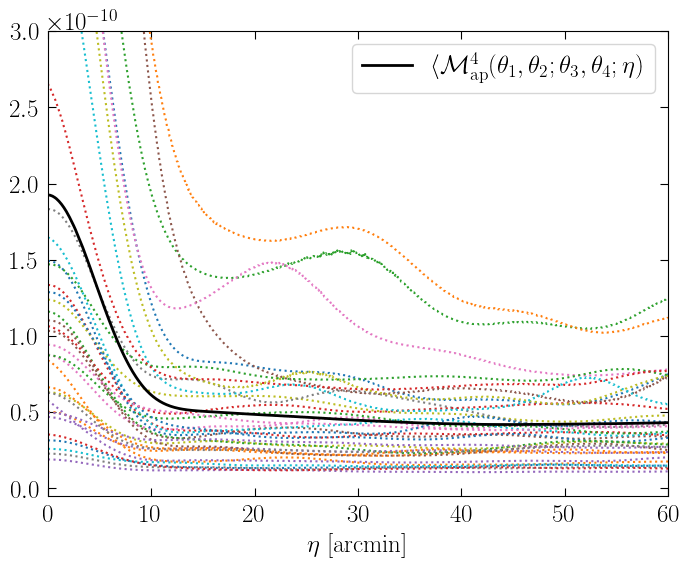

In [91]:
for i in range(35):
    plt.plot(thetas_mean[:1999]*180/np.pi*60,
#              Efunction(thetas_mean[:1999],L)*thetas_mean[:1999]*
             results_mapsq_mapsq[i,1,1,2,2,:1999],#-map_squared_mean[3,3]**2,
             linestyle=':')
plt.plot(thetas_mean[:1999]*180/np.pi*60,
#          Efunction(thetas_mean[:1999],L)*thetas_mean[:1999]*
         _results_mapsq_mapsq_mean[1,1,2,2,:1999],#-(map_squared_mean[3,3]**2),
         linewidth=2,color='black',label=r"$\langle\mathcal{M}_\mathrm{ap}^4(\theta_1,\theta_2;\theta_3,\theta_4;\eta)$")

plt.legend()
plt.ylim(-0.05*10**-10,3*10**-10)
plt.xlim(0,60)
plt.xlabel(r"$\eta$ [arcmin]")
# plt.yscale("log")
# plt.plot(0,map_squared_mean[0,0],marker='o',color='black')
# plt.xlim(-0.1,1)
# plt.plot(thetas_mean[:500],Efunction(thetas_mean[:500],L)/10**4.5,color='red')

In [136]:
map_map_functions = {}
mapsq_map_functions = {}
map_mapcu_functions = {}
mapsq_mapsq_functions = {}
mapcu_mapcu_functions = {}

def index_of(theta_ap):
    return int(round(mlog(theta_ap,2)))-1

for i in range(n_theta_ap):
    for j in range(i,n_theta_ap):
        map_map_functions["{}_{}".format(all_theta_ap[i],all_theta_ap[j])] = interp1d(thetas_mean,
                                                                                      results_map_map_mean[i,j],
                                        bounds_error=False,fill_value=0)
        for k in range(n_theta_ap):
            mapsq_map_functions["{}_{};{}".format(all_theta_ap[i],all_theta_ap[j],all_theta_ap[k])] = interp1d(thetas_mean,
                                                                                                               results_mapsq_map_mean[i,j,k],
                                        bounds_error=False,fill_value=0)
            

            
for i in range(n_theta_ap):
    for j in range(i,n_theta_ap):
        for ii in range(n_theta_ap):
            for jj in range(ii,n_theta_ap):
                mapsq_mapsq_functions["{}_{};{}_{}".format(all_theta_ap[i],all_theta_ap[j],
                                                                all_theta_ap[ii],all_theta_ap[jj])] \
                    = interp1d(thetas_mean,
                              results_mapsq_mapsq_mean[i,j,ii,jj],
                                bounds_error=False,fill_value=0)

for i in range(n_theta_ap):
    for j in range(i,n_theta_ap):
        for k in range(j,n_theta_ap):
            for ii in range(n_theta_ap):
                map_mapcu_functions["{};{}_{}_{}".format(all_theta_ap[ii],
                                                         all_theta_ap[i],
                                                        all_theta_ap[j],
                                                        all_theta_ap[k])] \
                    = interp1d(thetas_mean,results_map_mapcu_mean[ii,i,j,k],bounds_error=False,fill_value=0)
                for jj in range(ii,n_theta_ap):
                    for kk in range(jj,n_theta_ap):
                        mapcu_mapcu_functions["{}_{}_{};{}_{}_{}".format(all_theta_ap[i],all_theta_ap[j],all_theta_ap[k],
                                                                        all_theta_ap[ii],all_theta_ap[jj],all_theta_ap[kk])] \
                            = interp1d(thetas_mean,
                                      results_mapcu_mapcu_mean[i,j,k,ii,jj,kk],
                                        bounds_error=False,fill_value=0)
            

def get_map_map_function(th1,th2):
    if(th1>th2):
        return map_map_functions["{}_{}".format(th2,th1)]
    else:
        return map_map_functions["{}_{}".format(th1,th2)]
    
def get_mapsq_map_function(th1,th2,th3):
    if(th1>th2):
        return mapsq_map_functions["{}_{};{}".format(th2,th1,th3)]
    else:
        return mapsq_map_functions["{}_{};{}".format(th1,th2,th3)]
    
def get_map_mapcu_function(th1,th2,th3,th4):
    _th2,_th3,_th4 = np.sort([th2,th3,th4])
    return map_mapcu_functions["{};{}_{}_{}".format(th1,_th2,_th3,_th4)]
    
def get_mapsq_mapsq_function(th1,th2,th3,th4):
    _th1,_th2 = np.sort([th1,th2])
    _th3,_th4 = np.sort([th3,th4])
    return mapsq_mapsq_functions["{}_{};{}_{}".format(_th1,_th2,_th3,_th4)]
    
def get_mapcu_mapcu_function(th1,th2,th3,th4,th5,th6):
    _th1,_th2,_th3 = np.sort([th1,th2,th3])
    _th4,_th5,_th6 = np.sort([th4,th5,th6])
    return mapcu_mapcu_functions["{}_{}_{};{}_{}_{}".format(_th1,_th2,_th3,_th4,_th5,_th6)] 

def map_map_cubed(th1,th2,th3,th4,th5,th6,eta):
    return get_map_map_function(th1,th2)(eta)*get_map_map_function(th3,th4)(eta)*get_map_map_function(th5,th6)(eta)

def map_map_cubed_T2(th1,th2,th3,th4,th5,th6,eta):
    idx1 = index_of(th1)
    idx2 = index_of(th2)
    idx3 = index_of(th3)
    idx4 = index_of(th4)
    return map_squared_mean[idx1,idx2]*map_squared_mean[idx3,idx4]*get_map_map_function(th5,th6)(eta)

def map_map_cubed_T2_test(th1,th2,th3,th4,th5,th6):
    idx1 = index_of(th1)
    idx2 = index_of(th2)
    idx3 = index_of(th3)
    idx4 = index_of(th4)
    idx5 = index_of(th5)
    idx6 = index_of(th6)
    
    return map_squared_mean[idx1,idx2]*map_squared_mean[idx3,idx4] \
                *np.mean(map_single[:,idx5]*map_single[:,idx6],axis=0)


def map_map_mapsq_mapsq_T5(th1,th2,th3,th4,th5,th6,eta):
    return get_map_map_function(th1,th2)(eta)*get_mapsq_mapsq_function(th3,th4,th5,th6)(eta)

def map_map_map_mapcu_T6_test(th1,th2,th3,th4,th5,th6):
    idx1 = index_of(th1)
    idx2 = index_of(th2)
    idx3 = index_of(th3)
    idx4 = index_of(th4)
    idx5 = index_of(th5)
    idx6 = index_of(th6)

    return map_squared_mean[idx1,idx2]*np.mean(map_single[:,idx3]*map_cubed[:,idx4,idx5,idx6],axis=0)
    

In [132]:
from scipy.special import jv

def calculateGaussianMap2Covariance(th1,th2,L):
    mysum = lambda eta: (get_map_map_function(th1,th2)(eta))**2
    integrand = lambda eta: eta*Efunction(eta,L)*mysum(eta)
    result,err = quad(integrand,0,np.sqrt(2)*L)
#     *2 to account for permutations
    return 2*2*np.pi/(L*L)*result

def calculateGaussianMap2Covariance_test(th1,th2,L):
    idx1 = index_of(th1)
    idx2 = index_of(th2)
    result = np.mean((map_single[:,idx1]*map_single[:,idx2])**2,axis=0)
#     mysum = lambda eta: (get_map_map_function(th1,th2)(eta))**2
#     integrand = lambda eta: eta*Efunction(eta,L)*mysum(eta)
#     result,err = quad(integrand,0,np.sqrt(2)*L)
#     *2 to account for permutations
    return 2*result

def calculateNonGaussianMap2Covariance(th1,th2,L):
    mysum = lambda eta: get_mapsq_mapsq_function(th1,th1,th2,th2)(eta)
    integrand = lambda eta: eta*Efunction(eta,L)*mysum(eta)
    result,err = quad(integrand,0,np.sqrt(2)*L)
    return 2*np.pi/(L*L)*result

def gammat(survey="SLICS"):
    if(survey=="SLICS"):
        theta=10*np.pi/180/4096
        PS = np.loadtxt("/users/sven/Documents/code/results/powerspectrum_SLICS.dat")
    else:
        theta=4*np.pi/180/4096
        PS = np.loadtxt("/users/sven/Documents/code/results/powerspectrum_MR.dat")
        
    PSfunc = interp1d(PS[:,0],PS[:,1],bounds_error=False,fill_value=0)
    integrand = lambda ell: ell*PSfunc(ell)*4*(jv(1,ell*theta)/(ell*theta))**2
    return np.sqrt(1/(2*np.pi)*quad(integrand,0,np.inf)[0]/2)


def Qfunc(theta,theta_ap):
    """
    The Q filter function for the aperture mass calculation from Schneider et al. (2002)
    input: theta: aperture radius in arcmin
    output: Q [arcmin^-2]
    """
    thsq = (theta/theta_ap)**2
    res = thsq/(4*np.pi*self.theta_ap**2)*np.exp(-thsq/2)
    return res

def calculateMstar(theta_ap,survey = "SLICS"):
    gammatval = gammat(survey=survey)
    integrand = lambda theta: Qfunc(theta,theta_ap)**2*gammatval**2
    return quad(integrand,0,np.inf)[0]*2*np.pi
#     integrand
    
# def calculateMs()

In [133]:
map_map_covariance_gauss = np.zeros((n_theta_ap,n_theta_ap))
map_map_covariance_gauss_test = np.zeros((n_theta_ap,n_theta_ap))

map_map_covariance_nongauss = np.zeros((n_theta_ap,n_theta_ap))
map_map_covariance_SSC = np.zeros((n_theta_ap,n_theta_ap))

L = (4*60-8*16)/60/180*np.pi

for i in range(n_theta_ap):
    for j in range(i,n_theta_ap):
        mycov = calculateGaussianMap2Covariance(all_theta_ap[i],all_theta_ap[j],L)
        map_map_covariance_gauss[i,j] = mycov
        map_map_covariance_gauss[j,i] = mycov
        mycov_nongauss = calculateNonGaussianMap2Covariance(all_theta_ap[i],all_theta_ap[j],L)
        map_map_covariance_nongauss[i,j] = mycov_nongauss-mycov-map_squared_mean[i,i]*map_squared_mean[j,j]
        map_map_covariance_nongauss[j,i] = mycov_nongauss-mycov-map_squared_mean[i,i]*map_squared_mean[j,j]
        mycov_SSC = calculateMap2SSC(all_theta_ap[i],all_theta_ap[j],L)
        map_map_covariance_SSC[i,j] = mycov_SSC
        map_map_covariance_SSC[j,i] = mycov_SSC
        mycov = calculateGaussianMap2Covariance_test(all_theta_ap[i],all_theta_ap[j],L)
        map_map_covariance_gauss_test[i,j] = mycov
        map_map_covariance_gauss_test[j,i] = mycov

cov_measured = np.cov(np.einsum("ijj->ij",map_squared).T)
cov_measured.shape

(4, 4)

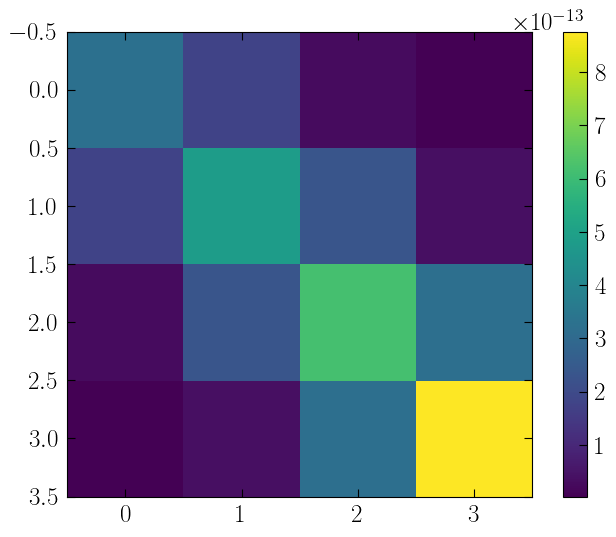

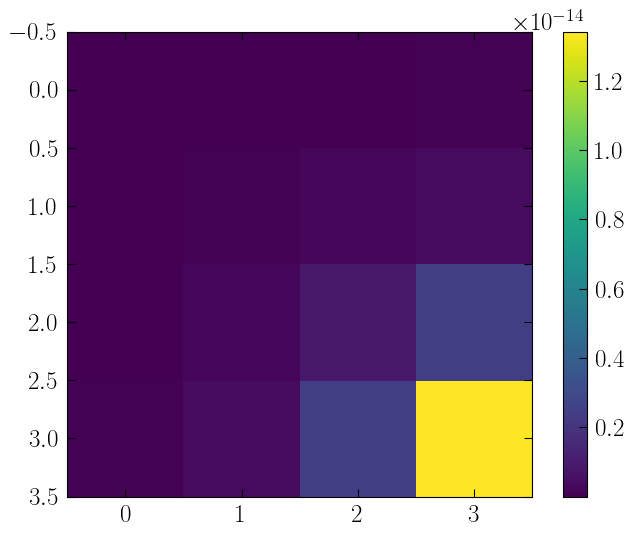

In [134]:
plt.imshow(map_map_covariance_gauss)
plt.colorbar()
plt.show()

plt.imshow(map_map_covariance_gauss_test)
plt.colorbar()
plt.show()

In [137]:
def calculateT1(th1,th2,th3,th4,th5,th6,L):
    mysum = lambda eta: map_map_cubed(th1,th4,th2,th5,th3,th6,eta) \
                    +   map_map_cubed(th1,th4,th2,th6,th3,th5,eta) \
                    +   map_map_cubed(th1,th5,th2,th4,th3,th6,eta) \
                    +   map_map_cubed(th1,th5,th2,th6,th3,th4,eta) \
                    +   map_map_cubed(th1,th6,th2,th4,th3,th5,eta) \
                    +   map_map_cubed(th1,th6,th2,th5,th3,th4,eta) 

    integrand = lambda eta: eta*Efunction(eta,L)*mysum(eta)
#     print(map_correlation_function(100.))
    result,err = quad(integrand,0,np.sqrt(2)*L)
#     result = trapz(integrand(thetas_mean),thetas_mean)
    return 2*np.pi/(L*L)*result

def calculateT2(th1,th2,th3,th4,th5,th6,L):
    mysum = lambda eta: map_map_cubed_T2(th1,th2,th4,th5,th3,th6,eta) \
                        + map_map_cubed_T2(th1,th2,th4,th6,th3,th5,eta) \
                        + map_map_cubed_T2(th1,th2,th5,th6,th3,th4,eta) \
                        + map_map_cubed_T2(th1,th3,th4,th5,th2,th6,eta) \
                        + map_map_cubed_T2(th1,th3,th4,th6,th2,th5,eta) \
                        + map_map_cubed_T2(th1,th3,th5,th6,th2,th4,eta) \
                        + map_map_cubed_T2(th2,th3,th4,th5,th1,th6,eta) \
                        + map_map_cubed_T2(th2,th3,th4,th6,th1,th5,eta) \
                        + map_map_cubed_T2(th2,th3,th5,th6,th1,th4,eta)
    integrand = lambda eta: eta*Efunction(eta,L)*mysum(eta)
#     result,err = quad(integrand,0,np.sqrt(2)*L)
    result = trapz(integrand(thetas_mean),thetas_mean)
    return 2*np.pi/(L*L)*result

def calculateT2_test(th1,th2,th3,th4,th5,th6,L):
    result = map_map_cubed_T2_test(th1,th2,th4,th5,th3,th6) \
                        + map_map_cubed_T2_test(th1,th2,th4,th6,th3,th5) \
                        + map_map_cubed_T2_test(th1,th2,th5,th6,th3,th4) \
                        + map_map_cubed_T2_test(th1,th3,th4,th5,th2,th6) \
                        + map_map_cubed_T2_test(th1,th3,th4,th6,th2,th5) \
                        + map_map_cubed_T2_test(th1,th3,th5,th6,th2,th4) \
                        + map_map_cubed_T2_test(th2,th3,th4,th5,th1,th6) \
                        + map_map_cubed_T2_test(th2,th3,th4,th6,th1,th5) \
                        + map_map_cubed_T2_test(th2,th3,th5,th6,th1,th4)
    return result

def calculateT5raw(th1,th2,th3,th4,th5,th6,L):
    mysum = lambda eta: map_map_mapsq_mapsq_T5(th1,th4,th2,th3,th5,th6,eta) \
                        + map_map_mapsq_mapsq_T5(th1,th5,th2,th3,th4,th6,eta) \
                        + map_map_mapsq_mapsq_T5(th1,th6,th2,th3,th4,th5,eta) \
                        + map_map_mapsq_mapsq_T5(th2,th4,th1,th3,th5,th6,eta) \
                        + map_map_mapsq_mapsq_T5(th2,th5,th1,th3,th4,th6,eta) \
                        + map_map_mapsq_mapsq_T5(th2,th6,th1,th3,th4,th5,eta) \
                        + map_map_mapsq_mapsq_T5(th3,th4,th1,th2,th5,th6,eta) \
                        + map_map_mapsq_mapsq_T5(th3,th5,th1,th2,th4,th6,eta) \
                        + map_map_mapsq_mapsq_T5(th3,th6,th1,th2,th4,th5,eta)
    integrand = lambda eta: eta*Efunction(eta,L)*mysum(eta)
    result,err = quad(integrand,0,np.sqrt(2)*L)
#     result = trapz(integrand(thetas_mean),thetas_mean)
    return 2*np.pi/(L*L)*result


def calculateT6raw(th1,th2,th3,th4,th5,th6,L):
    mysum = lambda eta: map_map_map_mapcu_T6(th1,th2,th3,th4,th5,th6,eta) \
                        + map_map_map_mapcu_T6(th1,th3,th2,th4,th5,th6,eta) \
                        + map_map_map_mapcu_T6(th2,th3,th1,th4,th5,th6,eta) \
                        + map_map_map_mapcu_T6(th4,th5,th6,th1,th2,th3,eta) \
                        + map_map_map_mapcu_T6(th4,th6,th5,th1,th2,th3,eta) \
                        + map_map_map_mapcu_T6(th5,th6,th4,th1,th2,th3,eta) 
    integrand = lambda eta: eta*Efunction(eta,L)*mysum(eta)
    result,err = quad(integrand,0,np.sqrt(2)*L)
#     result = trapz(integrand(thetas_mean),thetas_mean)
    return 2*np.pi/(L*L)*result

def calculateT6raw_test(th1,th2,th3,th4,th5,th6,L):
    result = map_map_map_mapcu_T6_test(th1,th2,th3,th4,th5,th6) \
                        + map_map_map_mapcu_T6_test(th1,th3,th2,th4,th5,th6) \
                        + map_map_map_mapcu_T6_test(th2,th3,th1,th4,th5,th6) \
                        + map_map_map_mapcu_T6_test(th4,th5,th6,th1,th2,th3) \
                        + map_map_map_mapcu_T6_test(th4,th6,th5,th1,th2,th3) \
                        + map_map_map_mapcu_T6_test(th5,th6,th4,th1,th2,th3) 
    return result


def calculateT4(th1,th2,th3,th4,th5,th6,L):
    mysum = lambda eta: get_mapsq_map_function(th1,th2,th4)(eta)*get_mapsq_map_function(th5,th6,th3)(eta) \
                    + get_mapsq_map_function(th1,th2,th5)(eta)*get_mapsq_map_function(th4,th6,th3)(eta) \
                    + get_mapsq_map_function(th1,th2,th6)(eta)*get_mapsq_map_function(th4,th5,th3)(eta) \
                    + get_mapsq_map_function(th1,th3,th4)(eta)*get_mapsq_map_function(th5,th6,th2)(eta) \
                    + get_mapsq_map_function(th1,th3,th5)(eta)*get_mapsq_map_function(th4,th6,th2)(eta) \
                    + get_mapsq_map_function(th1,th3,th6)(eta)*get_mapsq_map_function(th4,th5,th2)(eta) \
                    + get_mapsq_map_function(th4,th5,th1)(eta)*get_mapsq_map_function(th2,th3,th6)(eta) \
                    + get_mapsq_map_function(th4,th6,th1)(eta)*get_mapsq_map_function(th2,th3,th5)(eta) \
                    + get_mapsq_map_function(th5,th6,th1)(eta)*get_mapsq_map_function(th2,th3,th4)(eta)
                    
                    
    integrand = lambda eta: eta*Efunction(eta,L)*mysum(eta)
    result,err = quad(integrand,0,np.sqrt(2)*L)
#     result = trapz(integrand(thetas_mean),thetas_mean)
    return 2*np.pi/(L*L)*result

def calculateT7(th1,th2,th3,th4,th5,th6,L):
    integrand = lambda eta: eta*Efunction(eta,L)*get_mapcu_mapcu_function(th1,th2,th3,th4,th5,th6)(eta)
    result,err = quad(integrand,0,np.sqrt(2)*L)
#     result = trapz(integrand(thetas_mean),thetas_mean)
    return 2*np.pi/(L*L)*result


## $\mathcal{M}^2_\mathrm{ap}$ covariance

In [97]:
def term1_map2_SSC(th1,th2):
    _th1 = index_of(th1)
    _th2 = index_of(th2)
    term1 = np.mean(full_results_map_map[:,_th1,_th2]**2,axis=0)/full_results_map_map.shape[0]
    term2 = np.mean(full_results_map_map[:,_th1,_th2],axis=0)**2
    return -term1+term2

def calculateMap2SSC(th1,th2,L):
    result = trapz(thetas_mean*Efunction(thetas_mean,L)*term1_map2_SSC(th1,th2),thetas_mean)
    return 2/(L*L)*result

In [98]:
map_map_covariance_measured_gauss = np.loadtxt("/vol/euclid6/euclid6_ssd/sven/threepoint_with_laila/Map2_Covariances/MS/covMap2_square_Gauss_sigma_0.00_n_1048456.68_thetaMax_1.87_gpu.dat")
map_map_covariance_measured_nongauss = np.loadtxt("/vol/euclid6/euclid6_ssd/sven/threepoint_with_laila/Map2_Covariances/MS/covMap2_square_NonGauss_sigma_0.00_n_1048456.68_thetaMax_1.87_gpu.dat")

In [99]:
map_squared_mean.shape

(4, 4)

In [16]:
map_map_covariance_gauss = np.zeros((n_theta_ap,n_theta_ap))
map_map_covariance_nongauss = np.zeros((n_theta_ap,n_theta_ap))
map_map_covariance_SSC = np.zeros((n_theta_ap,n_theta_ap))

L = (4*60-8*16)/60/180*np.pi

for i in range(n_theta_ap):
    for j in range(i,n_theta_ap):
        mycov = calculateGaussianMap2Covariance(all_theta_ap[i],all_theta_ap[j],L)
        map_map_covariance_gauss[i,j] = mycov
        map_map_covariance_gauss[j,i] = mycov
        mycov_nongauss = calculateNonGaussianMap2Covariance(all_theta_ap[i],all_theta_ap[j],L)
        map_map_covariance_nongauss[i,j] = mycov_nongauss-mycov-map_squared_mean[i,i]*map_squared_mean[j,j]
        map_map_covariance_nongauss[j,i] = mycov_nongauss-mycov-map_squared_mean[i,i]*map_squared_mean[j,j]
        mycov_SSC = calculateMap2SSC(all_theta_ap[i],all_theta_ap[j],L)
        map_map_covariance_SSC[i,j] = mycov_SSC
        map_map_covariance_SSC[j,i] = mycov_SSC

cov_measured = np.cov(np.einsum("ijj->ij",map_squared).T)
cov_measured.shape

/usr/lib/python3/dist-packages/ipykernel_launcher.py:19: RuntimeWarning: Degrees of freedom <= 0 for slice
/users/sven/.local/lib/python3.6/site-packages/numpy/lib/function_base.py:2480: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/users/sven/.local/lib/python3.6/site-packages/numpy/lib/function_base.py:2480: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


(4, 4)

In [17]:
for i in range(4):
    print(map_map_covariance_nongauss[i]/map_map_covariance_measured_nongauss[i])

[-0.36220735 -0.15389593  0.02387942 -0.3845041 ]
[-0.15389593 -0.25716473 -0.11230427 -0.26653657]
[ 0.02387942 -0.11230427 -0.66323897 -1.04114719]
[-0.3845041  -0.26653657 -1.04114719 -5.83954194]


/usr/lib/python3/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.


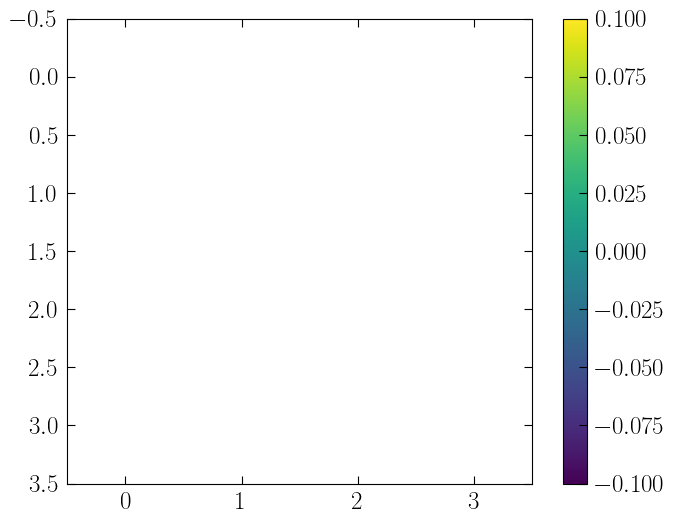

In [19]:
plt.imshow((map_map_covariance_nongauss-map_map_covariance_measured_nongauss)/map_map_covariance_SSC)
plt.colorbar()

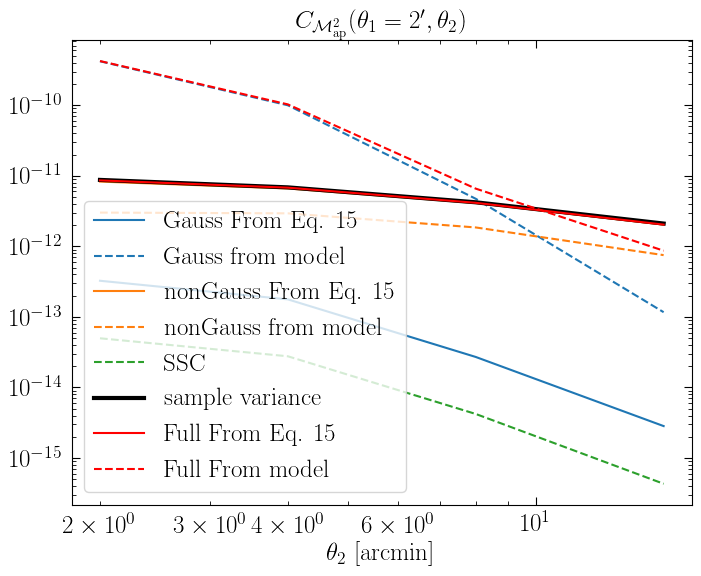

[1.01995595 1.01572347 0.98918394 0.96779549] [0.98412677 0.990325   0.98289268 0.96650399]


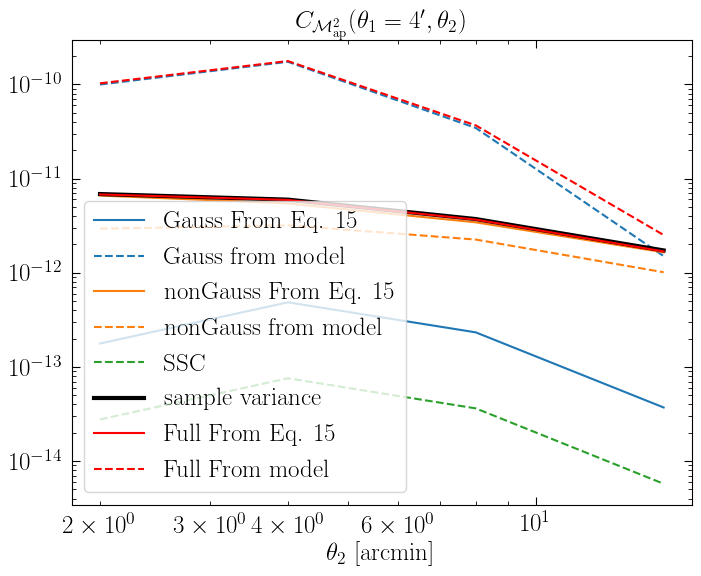

[1.01572347 1.07219802 1.04736143 0.99710965] [0.990325   0.99253134 0.98600221 0.97620039]


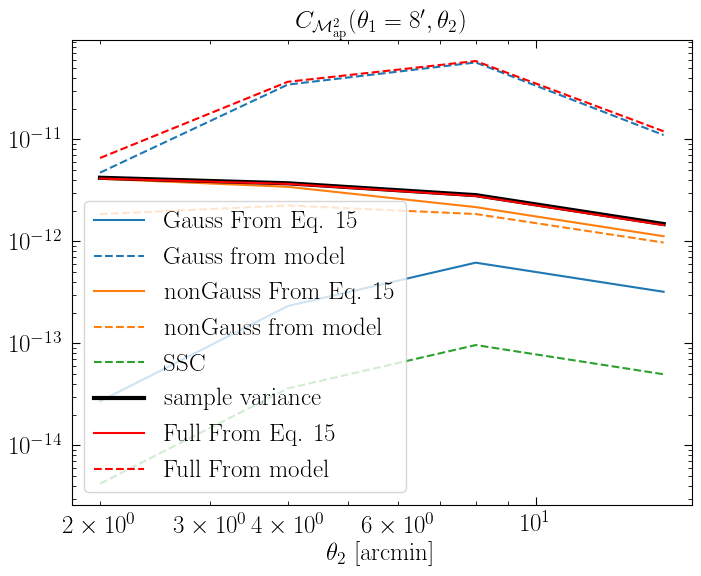

[0.98918394 1.04736143 1.19404972 1.18703827] [0.98289268 0.98600221 0.98084509 0.9755294 ]


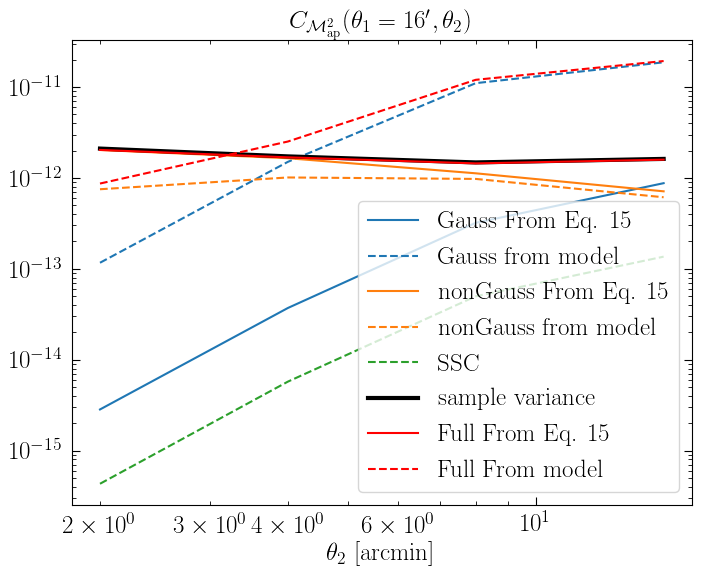

[0.96779549 0.99710965 1.18703827 1.50915285] [0.96650399 0.97620039 0.9755294  0.98088368]


In [68]:
for i in range(4):
    plt.plot(all_theta_ap,map_map_covariance_gauss[i],label=r'Gauss From Eq. 15',color='C0')
    plt.plot(all_theta_ap,map_map_covariance_measured_gauss[i],label='Gauss from model',color='C0',linestyle='--')
    plt.plot(all_theta_ap,map_map_covariance_nongauss[i],label=r'nonGauss From Eq. 15',color='C1')
    plt.plot(all_theta_ap,map_map_covariance_measured_nongauss[i],label='nonGauss from model',color='C1',linestyle='--')
    plt.plot(all_theta_ap,map_map_covariance_SSC[i],label='SSC',color='C2',linestyle='--')
   
    plt.plot(all_theta_ap,cov_measured[i],label='sample variance',color='black',linewidth=3)

    plt.plot(all_theta_ap,map_map_covariance_gauss[i]+map_map_covariance_nongauss[i],
             label=r'Full From Eq. 15',color='red')
    
    plt.plot(all_theta_ap,map_map_covariance_measured_gauss[i]+map_map_covariance_measured_nongauss[i],
             label=r'Full From model',color='red',linestyle='--')

    plt.yscale('log')
    plt.xscale('log')
    plt.title(r"$C_{\mathcal{M}_\mathrm{ap}^2}"+r"(\theta_1={:d}',\theta_2)$".format(all_theta_ap[i]))
    plt.xlabel(r'$\theta_2$ [arcmin]')
    plt.legend()
    plt.show()
    print((map_map_covariance_gauss[i]+map_map_covariance_nongauss[i]+2*np.pi*map_map_covariance_SSC[i])/cov_measured[i],
         (map_map_covariance_gauss[i]+map_map_covariance_nongauss[i])/cov_measured[i])

In [28]:
np.savetxt("/vol/euclid6/euclid6_ssd/sven/threepoint_with_laila/Map3_Covariances/Ti_from_MS/T_gauss_for_map2.dat",map_map_covariance)

NameError: name 'map_map_covariance' is not defined

## $\mathcal{M}^3_\mathrm{ap}$ covariance

In [110]:
model = {}

model["T2"] = np.loadtxt("/vol/euclid6/euclid6_ssd/sven/threepoint_with_laila/Map3_Covariances/MS/cov_square_term2Numerical_sigma_0.00_n_1048456.68_thetaMax_1.87_gpu.dat")
# model["T6"] = np.zeros((20,20))
model["T6"] = np.loadtxt("/vol/euclid6/euclid6_ssd/sven/threepoint_with_laila/Map3_Covariances/MS/cov_square_term6Numerical_sigma_0.00_n_1048456.68_thetaMax_1.87_gpu.dat")
model["T1"] = np.loadtxt("/vol/euclid6/euclid6_ssd/sven/threepoint_with_laila/Map3_Covariances/MS/cov_infinite_term1Numerical_sigma_0.00_n_1048456.68_thetaMax_1.87_gpu.dat")
model["T5"] = np.loadtxt("/vol/euclid6/euclid6_ssd/sven/threepoint_with_laila/Map3_Covariances/MS/cov_infinite_term5Numerical_sigma_0.00_n_1048456.68_thetaMax_1.87_gpu.dat")
model["T4"] = np.loadtxt("/vol/euclid6/euclid6_ssd/sven/threepoint_with_laila/Map3_Covariances/MS/cov_infinite_term4Numerical_sigma_0.00_n_1048456.68_thetaMax_1.87_gpu.dat")
model["T7"] = np.loadtxt("/vol/euclid6/euclid6_ssd/sven/threepoint_with_laila/Map3_Covariances/MS/cov_infinite_term7Numerical_sigma_0.00_n_1048456.68_thetaMax_1.87_gpu.dat")

direct_measured = {}
direct_measured["cov"] = np.loadtxt("/vol/euclid6/euclid6_ssd/sven/threepoint_with_laila/Map3_Covariances/MS/cov_MS_fft_sigma_0.00_n_1048576.00_thetaMax_1.87.dat")
direct_measured["data"] = np.mean(np.loadtxt("/vol/euclid6/euclid6_ssd/sven/threepoint_with_laila/Map3_Covariances/MS/map_cubed_our_thetas/map_cubed"),axis=0)


In [138]:
T1_sims = np.zeros((20,20))
T2_sims = np.zeros((20,20))
T2_sims_test = np.zeros((20,20))

T4_sims = np.zeros((20,20))
T5raw_sims = np.zeros((20,20))
T6raw_sims = np.zeros((20,20))
T6raw_sims_test = np.zeros((20,20))

allT_sims = np.zeros((20,20))
L = (4*60-8*16)/60/180*np.pi
idx = -1

print(n_theta_ap)
for i in range(n_theta_ap):
    for j in range(i,n_theta_ap):
        for k in range(j,n_theta_ap):
            idy = -1
            idx += 1
            for ii in range(n_theta_ap):
                for jj in range(ii,n_theta_ap):
                    for kk in range(jj,n_theta_ap):
                        idy += 1
                        T1_sims[idx,idy] = calculateT1(all_theta_ap[i],all_theta_ap[j],all_theta_ap[k],
                                                      all_theta_ap[ii],all_theta_ap[jj],all_theta_ap[kk],L)
                        T2_sims[idx,idy] = calculateT2(all_theta_ap[i],all_theta_ap[j],all_theta_ap[k],
                              all_theta_ap[ii],all_theta_ap[jj],all_theta_ap[kk],L)
                        T2_sims_test[idx,idy] = calculateT2_test(all_theta_ap[i],all_theta_ap[j],all_theta_ap[k],
                              all_theta_ap[ii],all_theta_ap[jj],all_theta_ap[kk],L)
                        T4_sims[idx,idy] = calculateT4(all_theta_ap[i],all_theta_ap[j],all_theta_ap[k],
                              all_theta_ap[ii],all_theta_ap[jj],all_theta_ap[kk],L)
                        T5raw_sims[idx,idy] = calculateT5raw(all_theta_ap[i],all_theta_ap[j],all_theta_ap[k],
                              all_theta_ap[ii],all_theta_ap[jj],all_theta_ap[kk],L)
                        T6raw_sims[idx,idy] = calculateT6raw(all_theta_ap[i],all_theta_ap[j],all_theta_ap[k],
                              all_theta_ap[ii],all_theta_ap[jj],all_theta_ap[kk],L)
                        T6raw_sims_test[idx,idy] = calculateT6raw_test(all_theta_ap[i],all_theta_ap[j],all_theta_ap[k],
                              all_theta_ap[ii],all_theta_ap[jj],all_theta_ap[kk],L)
                        allT_sims[idx,idy] = calculateT7(all_theta_ap[i],all_theta_ap[j],all_theta_ap[k],
                              all_theta_ap[ii],all_theta_ap[jj],all_theta_ap[kk],L)
                        progressBar("Calculating Ti",idx*20+idy,400)

                        

T5_sims = T5raw_sims - 3*T1_sims - T2_sims
T6_sims = T6raw_sims - 2*T2_sims
T6_sims_test = T6raw_sims_test - 2*T2_sims


measured_corrf = {}
measured_corrf["T1"] = T1_sims
measured_corrf["T2"] = T2_sims
measured_corrf["T4"] = T4_sims
measured_corrf["T5"] = T5_sims
measured_corrf["T6"] = T6_sims
measured_corrf["T7"] = allT_sims - T1_sims - T2_sims - direct_measured["data"]**2 - T4_sims - T5_sims - T6_sims

4
Calculating Ti       : [------------------------>]100%

In [145]:
measured_corrf["T2t"] = T2_sims_test
measured_corrf["T6t"] = T6raw_sims_test - 2*T2_sims_test


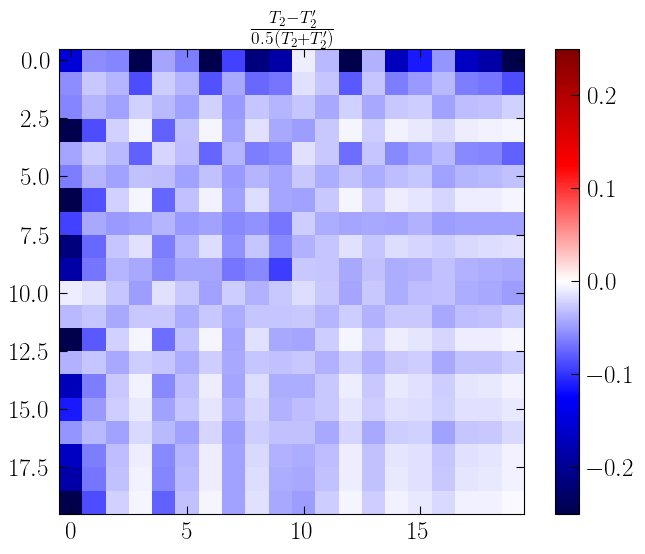

In [150]:
plt.imshow(2*(measured_corrf["T2"]-measured_corrf["T2t"])/(measured_corrf["T2"]+measured_corrf["T2t"]),
          vmin=-0.25,vmax=0.25,cmap='seismic')
plt.title(r"$\frac{T_2-T_2'}{0.5(T_2+T_2')}$")
plt.colorbar()
plt.savefig("/users/sven/Sciebo/tex_files/misc/covariance_via_correlations/T2_comparison.pdf")
plt.show()

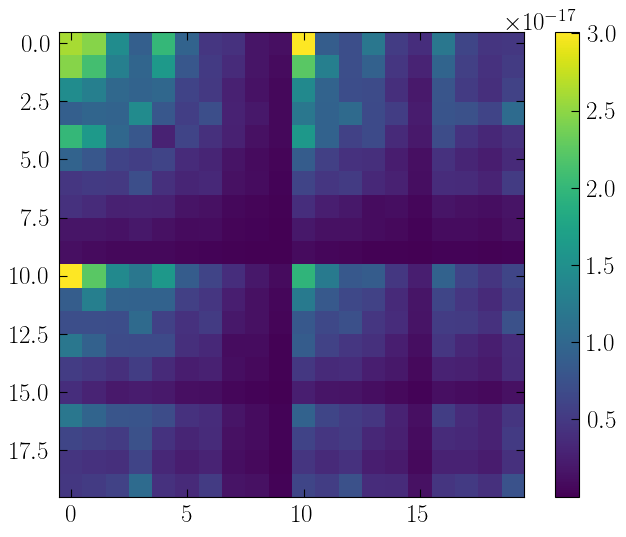

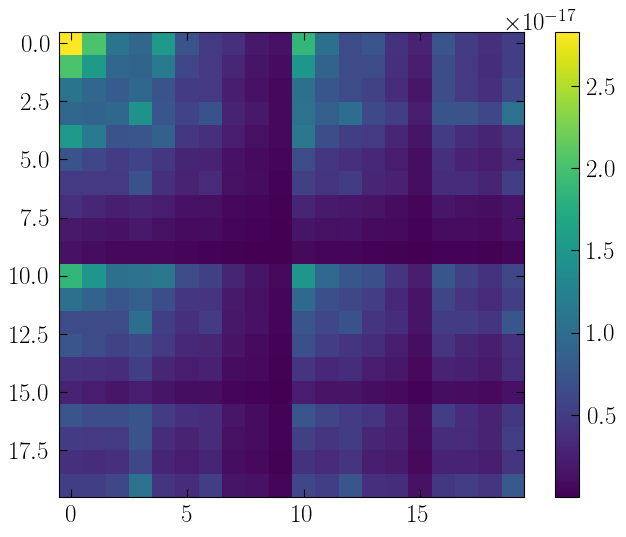

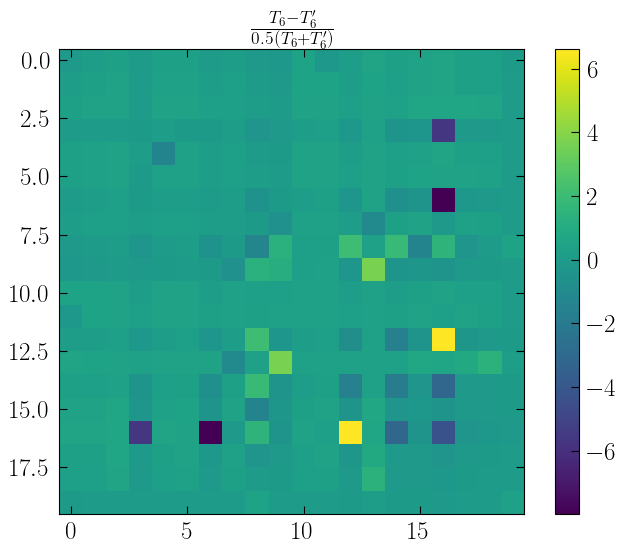

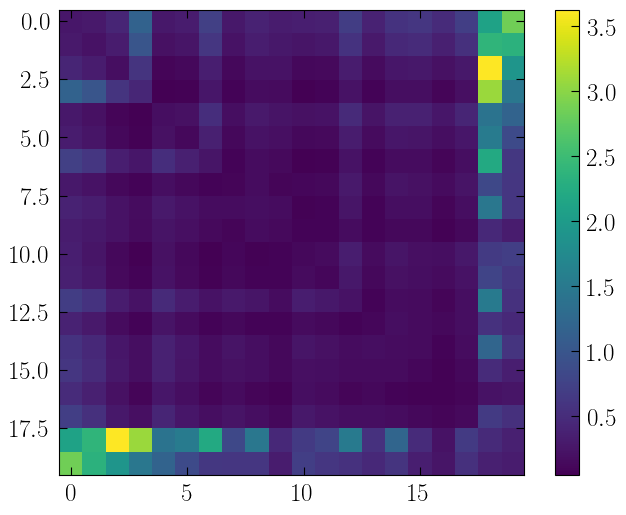

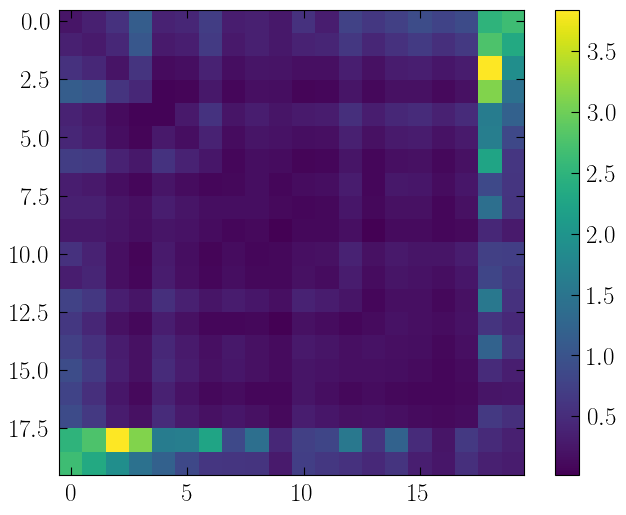

In [148]:
plt.imshow(T6raw_sims)
plt.colorbar()
plt.show()

plt.imshow(T6raw_sims_test)
plt.colorbar()
plt.show()

plt.imshow(2*(measured_corrf["T6"]-measured_corrf["T6t"])/(measured_corrf["T6"]+measured_corrf["T6t"]))
#           vmin=-0.5,vmax=0.5,cmap='seismic')
plt.title(r"$\frac{T_6-T_6'}{0.5(T_6+T_6')}$")
plt.colorbar()
plt.savefig("/users/sven/Sciebo/tex_files/misc/covariance_via_correlations/T6_comparison.pdf")
plt.show()

plt.imshow(T6raw_sims_test/model["T6"])
plt.colorbar()
plt.show()

plt.imshow(T6raw_sims/model["T6"])
plt.colorbar()
plt.show()

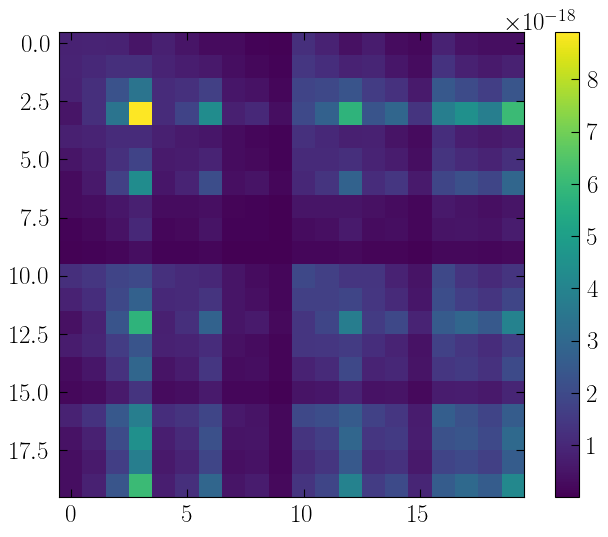

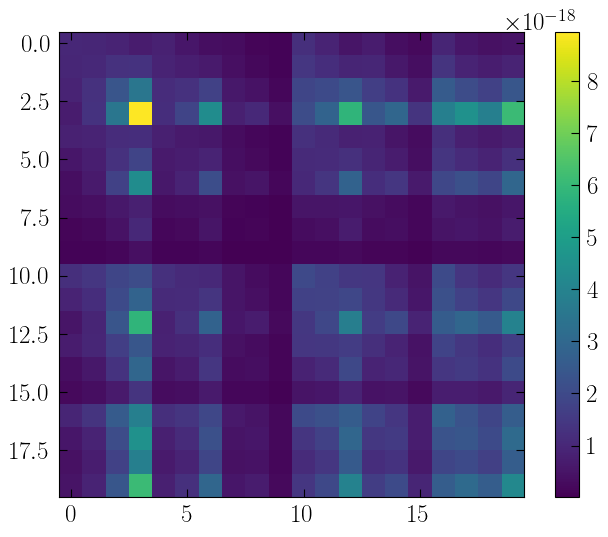

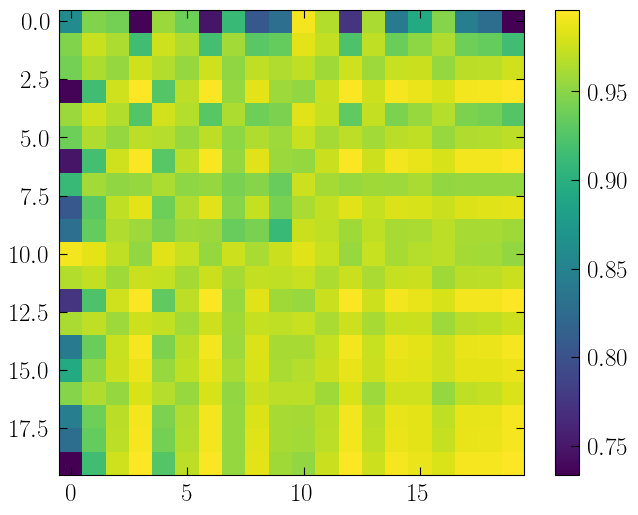

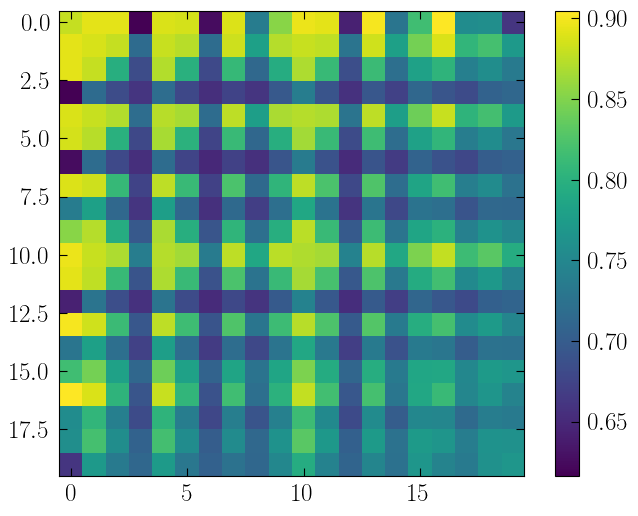

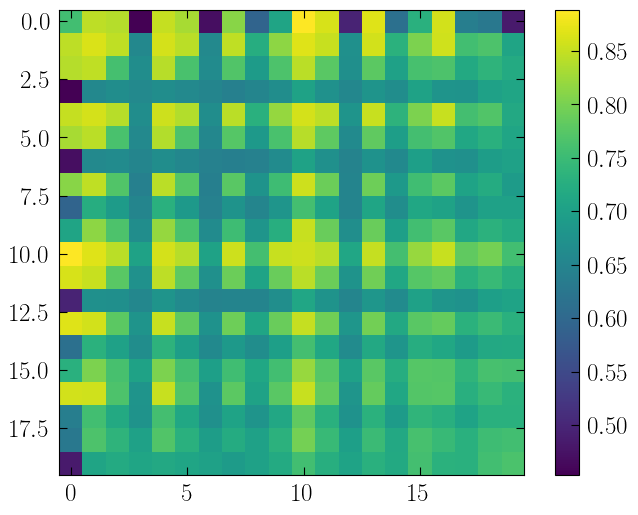

In [131]:
plt.imshow(T2_sims)
plt.colorbar()
plt.show()

plt.imshow(T2_sims_test)
plt.colorbar()
plt.show()

plt.imshow(T2_sims/T2_sims_test)
plt.colorbar()
plt.show()

plt.imshow(T2_sims_test/model["T2"])
plt.colorbar()
plt.show()

plt.imshow(T2_sims/model["T2"])
plt.colorbar()
plt.show()

In [ ]:
# T6_sims = T6raw_sims
# measured_corrf["T6"] = 4*T6raw_sims


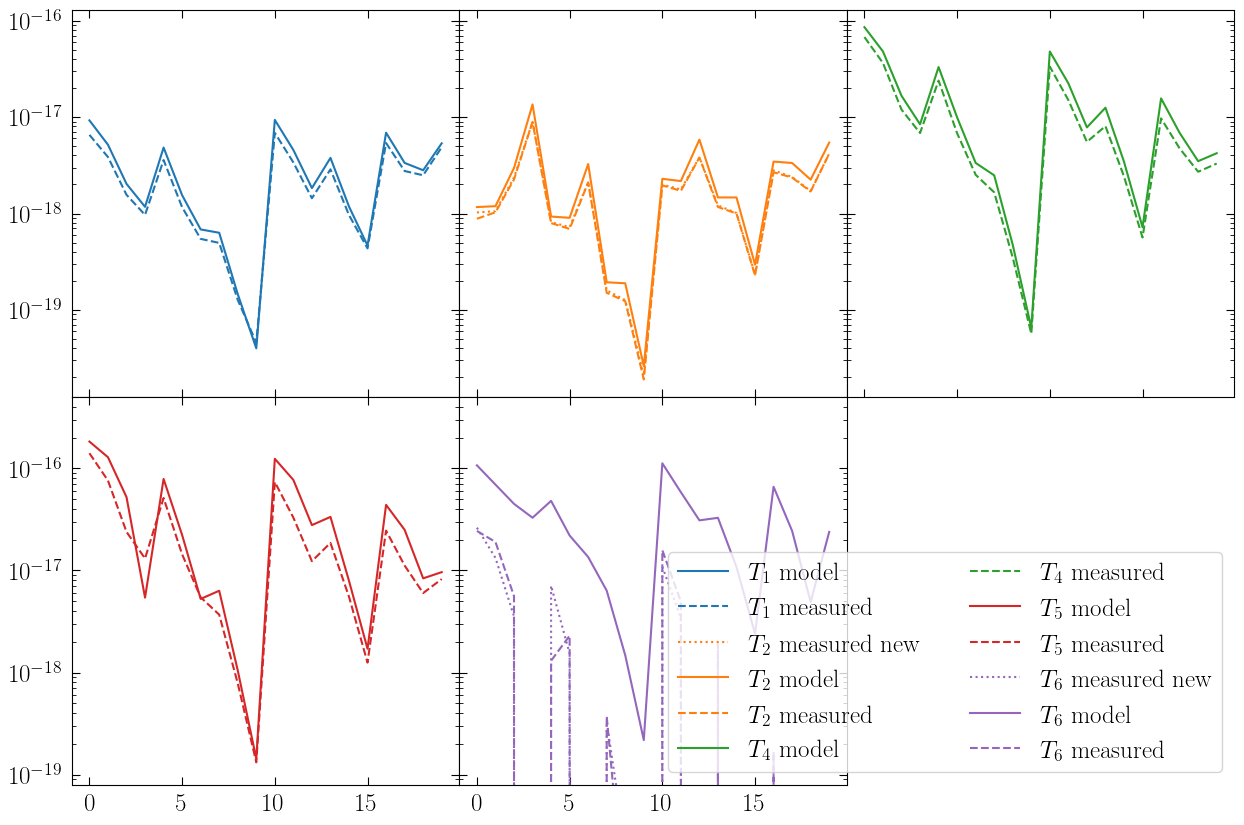

In [151]:
fig,ax = plt.subplots(2,3,figsize=(15,10),sharex=True,sharey="row")
plt.subplots_adjust(wspace=0,hspace=0)
for c,i in enumerate([1,2,4,5,6]):
    ax2 = c%3
    ax1 = c//3
    ax[ax1,ax2].plot(np.diag(model["T{}".format(i)]),color="C{}".format(c),label = r"$T_{}$ model".format(i))
    ax[ax1,ax2].plot(np.diag(measured_corrf["T{}".format(i)]),color="C{}".format(c),label=r"$T_{}$ measured".format(i),
            linestyle="--")
    if i in [2,6]:
        ax[ax1,ax2].plot(np.diag(measured_corrf["T{}t".format(i)]),color="C{}".format(c),label=r"$T_{}$ measured new".format(i),
            linestyle=":")
        ax[1,2].plot([],color="C{}".format(c),label=r"$T_{}$ measured new".format(i),
            linestyle=":")


    ax[ax1,ax2].set_yscale('log')
    ax[1,2].plot([],color="C{}".format(c),label = r"$T_{}$ model".format(i))
    ax[1,2].plot([],color="C{}".format(c),label=r"$T_{}$ measured".format(i),
            linestyle="--")

ax[1,2].set_ylim(8*10**-20,5*10**-16)
ax[1,2].legend(loc="lower right",ncol=2)
ax[1,2].axis('off')
plt.savefig("/users/sven/Sciebo/tex_files/misc/covariance_via_correlations/Ti_comparison_MS.pdf")
plt.show()

# for c,i in enumerate([7]):
# #     plt.plot(np.diag(model["T{}".format(i)])*10**6,color="C{}".format(c+5),label = r"$10^6\times T_{}$ model".format(i))
#     plt.plot(np.diag(measured_corrf["T{}".format(i)]),color="C{}".format(c+5),label=r"$T_{}$ measured".format(i),
#             linestyle="--")
#     plt.plot(np.diag(direct_measured["cov"]-T1_sims-T2_sims-T4_sims-T5_sims-T6_sims), color="C{}".format(c+5),
#             label=r"$T_{}$ from covariance".format(i),linestyle=':')
# plt.yscale('log')
# # plt.ylim(10**-19,10**-15)
# plt.legend(loc="lower right",bbox_to_anchor=(1.2,0))
# plt.show()


# SLICS covariance tests

In [234]:
all_los = np.arange(74,800)
all_los = np.arange(74,800)

n_los = len(all_los)
L = (10*60-8*16)/60/180*np.pi

all_theta_ap = [2,4,8,16]


n_theta_ap = len(all_theta_ap)
n_theta = 2000


mask = np.zeros(n_los,dtype=bool)

fpath = "/vol/euclid2/euclid2_raid2/sven/mapCorr_SLICS_for_T4_new/"

map_single = np.zeros((n_los,n_theta_ap))
map_squared = np.zeros((n_los,n_theta_ap,n_theta_ap))
map_cubed = np.zeros((n_los,n_theta_ap,n_theta_ap,n_theta_ap))
map_four = np.zeros((n_los,n_theta_ap,n_theta_ap,n_theta_ap,n_theta_ap))
map_six = np.zeros((n_los,n_theta_ap,n_theta_ap,n_theta_ap,n_theta_ap,n_theta_ap,n_theta_ap))

for x,los in enumerate(tqdm(all_los,desc="Reading map powers")):
    try:
        if(los==392):
            print(fpath+"map_single_los_{}.npy".format(los))
#         map_single[x] = np.load(fpath+"map_single_los_{}.npy".format(los))
        map_squared[x] = np.load(fpath+"map_squared_los_{}.npy".format(los))
        map_cubed[x] = np.load(fpath+"map_cubed_los_{}.npy".format(los))
        map_four[x] = np.load(fpath+"map_four_los_{}.npy".format(los))
        map_six[x] = np.load(fpath+"map_six_los_{}.npy".format(los))
        gg = np.load(fpath+"ggcorr_mapcu_{}_{}_{}_mapcu_{}_{}_{}_los_{}.npy".format(all_theta_ap[-1],all_theta_ap[-1],all_theta_ap[-1],all_theta_ap[-1],all_theta_ap[-1],all_theta_ap[-1],los))

        mask[x] = True
        
    except Exception as e:
        pass
    
print(np.sum(mask))

map_single = map_single[mask]
map_squared = map_squared[mask]
map_cubed = map_cubed[mask]
map_four = map_four[mask]
map_six = map_six[mask]



all_los = all_los[mask]
n_los = len(all_los)

results_map_map = np.zeros((n_los,n_theta_ap,n_theta_ap,n_theta))
results_mapsq_map = np.zeros((n_los,n_theta_ap,n_theta_ap,n_theta_ap,n_theta))
results_map_mapcu = np.zeros((n_los,n_theta_ap,n_theta_ap,n_theta_ap,n_theta_ap,n_theta))
results_mapsq_mapsq = np.zeros((n_los,n_theta_ap,n_theta_ap,n_theta_ap,n_theta_ap,n_theta))
results_mapcu_mapcu = np.zeros((n_los,n_theta_ap,n_theta_ap,n_theta_ap,n_theta_ap,n_theta_ap,n_theta_ap,n_theta))
mean_thetas = np.zeros(n_theta)

mask2 = np.ones(n_los,dtype=bool)

for x,los in enumerate(tqdm(all_los,desc="Reading map map")):
    for i in range(n_theta_ap):
        for j in range(i,n_theta_ap):
            try:
                gg = np.load(fpath+"ggcorr_map_{}_map_{}_los_{}.npy".format(all_theta_ap[i],all_theta_ap[j],los))
            except Exception as e:
                print(e)
                mask2[x]=0
                continue
            results_map_map[x,i,j] = gg[1]
            results_map_map[x,j,i] = gg[1]
mean_thetas = gg[0]/180*np.pi

   


# for x,los in enumerate(tqdm(all_los,desc="Reading mapsq map")):
#     for i in range(n_theta_ap):
#         for j in range(i,n_theta_ap):
#             for k in range(n_theta_ap):
#                 try:
#                     gg = np.load(fpath+"ggcorr_mapsq_{}_{}_map_{}_los_{}.npy".format(all_theta_ap[i],all_theta_ap[j],
#                                                                          all_theta_ap[k],los))
#                 except Exception as e:
#                     print(e)
#                     mask2[x]=0
#                     continue
#                 results_mapsq_map[x,i,j,k] = gg[1]
#                 results_mapsq_map[x,j,i,k] = gg[1]
    

# for x,los in enumerate(tqdm(all_los,desc="Reading map mapcu")):
#     for i in range(n_theta_ap):
#         for j in range(i,n_theta_ap):
#             for k in range(j,n_theta_ap):
#                 for ii in range(n_theta_ap):
#                     try:
#                         gg = np.load(fpath+"ggcorr_map_{}_mapcu_{}_{}_{}_los_{}.npy".format(all_theta_ap[ii],
#                                                                                    all_theta_ap[i],
#                                                                                    all_theta_ap[j],
#                                                                              all_theta_ap[k],los))
#                     except Exception as e:
#                         print(e)
#                         mask2[x]=0
#                         continue
#                     for idi,idj,idk in permutations([i,j,k]):
#                         results_map_mapcu[x,ii,idi,idj,idk] = gg[1]

    
for x,los in enumerate(tqdm(all_los,desc="Reading mapsq mapsq")):
    for i in range(n_theta_ap):
        for j in range(i,n_theta_ap):
            for ii in range(n_theta_ap):
                for jj in range(ii,n_theta_ap):
                    try:
                        gg = np.load(fpath+"ggcorr_mapsq_{}_{}_mapsq_{}_{}_los_{}.dat.npy".format(all_theta_ap[i],
                                                    all_theta_ap[j],
                                                    all_theta_ap[ii],
                                                    all_theta_ap[jj],
                                                    los))
                    except Exception as e:
                        print(e)
                        mask2[x]=0
                        continue
                    for idi,idj in permutations([i,j]):
                        for idii,idjj in permutations([ii,jj]):
                            results_mapsq_mapsq[x,idi,idj,idii,idjj] = gg[1]


# for x,los in enumerate(tqdm(all_los,desc="Reading mapcu mapcu")):
#     for i in range(n_theta_ap):
#         for j in range(i,n_theta_ap):
#             for k in range(j,n_theta_ap):
#                 for ii in range(n_theta_ap):
#                     for jj in range(ii,n_theta_ap):
#                         for kk in range(jj,n_theta_ap):
#                             try:
#                                 gg = np.load(fpath+"ggcorr_mapcu_{}_{}_{}_mapcu_{}_{}_{}_los_{}.npy".format(all_theta_ap[i],
#                                                             all_theta_ap[j],
#                                                             all_theta_ap[k],
#                                                             all_theta_ap[ii],
#                                                             all_theta_ap[jj],
#                                                             all_theta_ap[kk],
#                                                             los))
#                             except Exception as e:
#                                 print(e)
#                                 mask2[x]=0
#                                 continue
#                             for idi,idj,idk in permutations([i,j,k]):
#                                 for idii,idjj,idkk in permutations([ii,jj,kk]):
#                                     results_mapcu_mapcu[x,idi,idj,idk,idii,idjj,idkk] = gg[1]
        

# _results_map_map_mean = np.mean(results_map_map,axis=0)



/vol/euclid2/euclid2_raid2/sven/mapCorr_SLICS_for_T4_new/map_single_los_392.npy

630


In [241]:
# mask3 = np.any(np.abs((map_cubed_diag-np.mean(map_cubed_diag,axis=1)[:,None])/np.std(map_cubed_diag,axis=1)[:,None])>3,axis=0)
# mask3[50:] = True
mask3 = np.zeros(len(mask2),dtype=bool)
print(np.sum(mask3))


0


In [242]:
# map_single_mean = np.mean(map_single[~mask3],axis=0)
map_squared_mean = np.mean(map_squared[~mask3],axis=0)
map_cubed_mean = np.mean(map_cubed[~mask3],axis=0)
map_four_mean = np.mean(map_four[~mask3],axis=0)
map_six_mean = np.mean(map_six[~mask3],axis=0)




print(np.sum(mask2),len(mask2))
if(np.sum(mask2)==len(mask2)):
    print("Length matches. computing average")
    _results_map_map_mean = np.mean(results_map_map[~mask3],axis=0)
    _results_mapsq_map_mean = np.mean(results_mapsq_map[~mask3],axis=0)
    _results_map_mapcu_mean = np.mean(results_map_mapcu[~mask3],axis=0)
    _results_mapsq_mapsq_mean = np.mean(results_mapsq_mapsq[~mask3],axis=0)
    _results_mapcu_mapcu_mean = np.mean(results_mapcu_mapcu[~mask3],axis=0)

else:
    print("WARNING: Length does not match: {}/{}. Excluding los with missing elements".format(np.sum(mask2),len(mask2)))
    _results_map_map_mean = np.mean(results_map_map[np.logical_and(~mask3,mask2)],axis=0)
    _results_mapsq_map_mean = np.mean(results_mapsq_map[np.logical_and(~mask3,mask2)],axis=0)
    _results_map_mapcu_mean = np.mean(results_map_mapcu[np.logical_and(~mask3,mask2)],axis=0)
    _results_mapsq_mapsq_mean = np.mean(results_mapsq_mapsq[np.logical_and(~mask3,mask2)],axis=0)
    _results_mapcu_mapcu_mean = np.mean(results_mapcu_mapcu[np.logical_and(~mask3,mask2)],axis=0)


630 630
Length matches. computing average


In [243]:
_thetas_mean = np.load("/vol/euclid2/euclid2_raid2/sven/mapCorr_SLICS_for_T4_new/theta_bins.npy")*np.pi/180
thetas_mean = np.insert(_thetas_mean[:-1],0,0)
results_mapsq_map_mean = np.insert(_results_mapsq_map_mean[:,:,:,:-1],0,map_cubed_mean,axis=-1)
results_map_mapcu_mean = np.insert(_results_map_mapcu_mean[:,:,:,:,:-1],0,map_four_mean,axis=-1)
results_mapsq_mapsq_mean = np.insert(_results_mapsq_mapsq_mean[:,:,:,:,:-1],0,map_four_mean,axis=-1)
results_map_map_mean = np.insert(_results_map_map_mean[:,:,:-1],0,map_squared_mean,axis=-1)
results_mapcu_mapcu_mean = np.insert(_results_mapcu_mapcu_mean[:,:,:,:,:,:,:-1],0,map_six_mean,axis=-1)


Text(0.5, 0, '$\\eta$ [arcmin]')

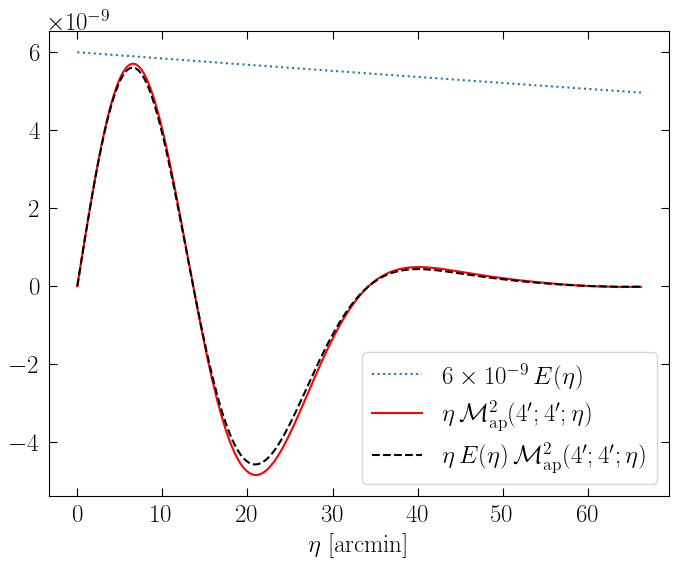

In [244]:
plt.plot(thetas_mean[:200]*180*60/np.pi,Efunction(thetas_mean[:200],L)*6*10**-9,
         color='C0',linestyle=':',label=r"$6\times 10^{-9}\, E(\eta)$")
plt.plot(thetas_mean[:200]*180*60/np.pi,thetas_mean[:200]*results_map_map_mean[2,2,:200],
         color='red',label=r"$\eta\, \mathcal{M}_\mathrm{ap}^2(4';4';\eta)$")
plt.plot(thetas_mean[:200]*180*60/np.pi,thetas_mean[:200]*results_map_map_mean[2,2,:200]*Efunction(thetas_mean[:200],L),
        color='black',linestyle='--',label=r"$\eta\, E(\eta)\,\mathcal{M}_\mathrm{ap}^2(4';4';\eta)$")
plt.legend()
plt.xlabel(r"$\eta$ [arcmin]")
# plt.savefig("/users/sven/Sciebo/tex_files/thesis/phd_thesis/figures/map2_correlation_multiplied_by_eoftheta.png",
#            dpi=200)

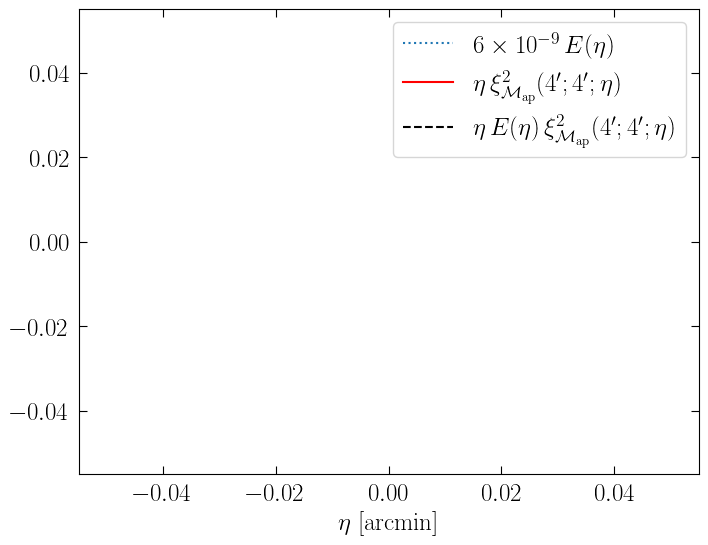

In [245]:
plt.plot([],
         color='C0',linestyle=':',label=r"$6\times 10^{-9}\, E(\eta)$")
plt.plot([],
         color='red',label=r"$\eta\, \xi_{\mathcal{M}_\mathrm{ap}}^2(4';4';\eta)$")
plt.plot([],
        color='black',linestyle='--',label=r"$\eta\, E(\eta)\,\xi_{\mathcal{M}_\mathrm{ap}}^2(4';4';\eta)$")
plt.legend()
plt.xlabel(r"$\eta$ [arcmin]")
plt.savefig("/home/sven/Sciebo/tex_files/thesis/phd_thesis/figures/map2_correlation_legend.png",
           dpi=200)

In [246]:
map_map_functions = {}
mapsq_map_functions = {}
map_mapcu_functions = {}
mapsq_mapsq_functions = {}
mapcu_mapcu_functions = {}

def index_of(theta_ap):
    return int(round(mlog(theta_ap,2)))-1

for i in range(n_theta_ap):
    for j in range(i,n_theta_ap):
        map_map_functions["{}_{}".format(all_theta_ap[i],all_theta_ap[j])] = interp1d(thetas_mean,
                                                                                      results_map_map_mean[i,j],
                                        bounds_error=False,fill_value=0)
        for k in range(n_theta_ap):
            mapsq_map_functions["{}_{};{}".format(all_theta_ap[i],all_theta_ap[j],all_theta_ap[k])] = interp1d(thetas_mean,
                                                                                                               results_mapsq_map_mean[i,j,k],
                                        bounds_error=False,fill_value=0)
            

            
for i in range(n_theta_ap):
    for j in range(i,n_theta_ap):
        for ii in range(n_theta_ap):
            for jj in range(ii,n_theta_ap):
                mapsq_mapsq_functions["{}_{};{}_{}".format(all_theta_ap[i],all_theta_ap[j],
                                                                all_theta_ap[ii],all_theta_ap[jj])] \
                    = interp1d(thetas_mean,
                              results_mapsq_mapsq_mean[i,j,ii,jj],
                                bounds_error=False,fill_value=0)

for i in range(n_theta_ap):
    for j in range(i,n_theta_ap):
        for k in range(j,n_theta_ap):
            for ii in range(n_theta_ap):
                map_mapcu_functions["{};{}_{}_{}".format(all_theta_ap[ii],
                                                         all_theta_ap[i],
                                                        all_theta_ap[j],
                                                        all_theta_ap[k])] \
                    = interp1d(thetas_mean,results_map_mapcu_mean[ii,i,j,k],bounds_error=False,fill_value=0)
                for jj in range(ii,n_theta_ap):
                    for kk in range(jj,n_theta_ap):
                        mapcu_mapcu_functions["{}_{}_{};{}_{}_{}".format(all_theta_ap[i],all_theta_ap[j],all_theta_ap[k],
                                                                        all_theta_ap[ii],all_theta_ap[jj],all_theta_ap[kk])] \
                            = interp1d(thetas_mean,
                                      results_mapcu_mapcu_mean[i,j,k,ii,jj,kk],
                                        bounds_error=False,fill_value=0)
            

def get_map_map_function(th1,th2):
    if(th1>th2):
        return map_map_functions["{}_{}".format(th2,th1)]
    else:
        return map_map_functions["{}_{}".format(th1,th2)]
    
def get_mapsq_map_function(th1,th2,th3):
    if(th1>th2):
        return mapsq_map_functions["{}_{};{}".format(th2,th1,th3)]
    else:
        return mapsq_map_functions["{}_{};{}".format(th1,th2,th3)]
    
def get_map_mapcu_function(th1,th2,th3,th4):
    _th2,_th3,_th4 = np.sort([th2,th3,th4])
    return map_mapcu_functions["{};{}_{}_{}".format(th1,_th2,_th3,_th4)]
    
def get_mapsq_mapsq_function(th1,th2,th3,th4):
    _th1,_th2 = np.sort([th1,th2])
    _th3,_th4 = np.sort([th3,th4])
    return mapsq_mapsq_functions["{}_{};{}_{}".format(_th1,_th2,_th3,_th4)]
    
def get_mapcu_mapcu_function(th1,th2,th3,th4,th5,th6):
    _th1,_th2,_th3 = np.sort([th1,th2,th3])
    _th4,_th5,_th6 = np.sort([th4,th5,th6])
    return mapcu_mapcu_functions["{}_{}_{};{}_{}_{}".format(_th1,_th2,_th3,_th4,_th5,_th6)] 

def map_map_cubed(th1,th2,th3,th4,th5,th6,eta):
    return get_map_map_function(th1,th2)(eta)*get_map_map_function(th3,th4)(eta)*get_map_map_function(th5,th6)(eta)

def map_map_cubed_T2(th1,th2,th3,th4,th5,th6,eta):
    idx1 = index_of(th1)
    idx2 = index_of(th2)
    idx3 = index_of(th3)
    idx4 = index_of(th4)
    return map_squared_mean[idx1,idx2]*map_squared_mean[idx3,idx4]*get_map_map_function(th5,th6)(eta)

def map_map_mapsq_mapsq_T5(th1,th2,th3,th4,th5,th6,eta):
    return get_map_map_function(th1,th2)(eta)*get_mapsq_mapsq_function(th3,th4,th5,th6)(eta)

def map_map_map_mapcu_T6(th1,th2,th3,th4,th5,th6,eta):
    idx1 = index_of(th1)
    idx2 = index_of(th2)
    return map_squared_mean[idx1,idx2]*get_map_mapcu_function(th3,th4,th5,th6)(eta)
    

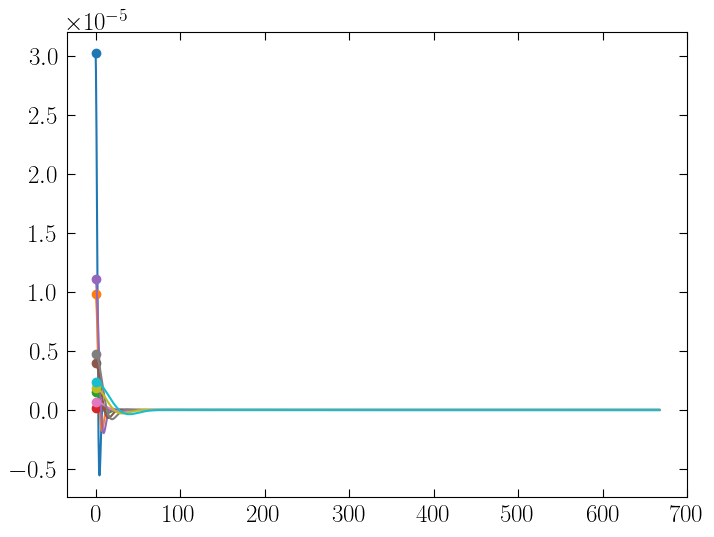

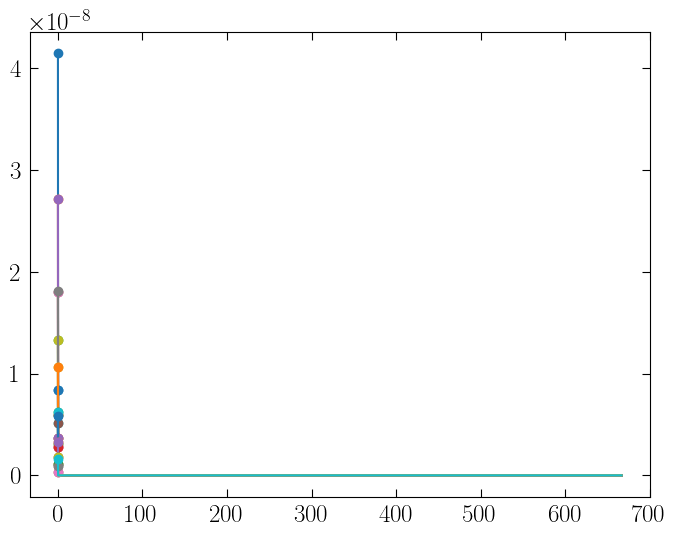

In [247]:
thetas = thetas_mean*180/np.pi*60
count = 0
for i in range(n_theta_ap):
    for j in range(i,n_theta_ap):
        th1 = all_theta_ap[i]
        th2 = all_theta_ap[j]
        plt.plot(thetas,Efunction(thetas,L=536)*results_map_map_mean[i,j],label=r"$<\mathcal{M}_\mathrm{ap}^2"+\
                 "({},{};\eta)>$".format(th1,th2),color="C{}".format(count))
        plt.plot(0,map_squared_mean[i,j],marker='o',color="C{}".format(count))
        count += 1
#         print(map_squared_mean[i,j])
# plt.plot(thetas,Efunction(thetas,L=536)*10**-5,color='black',label=r"$E(\theta)$")
# plt.xlim(0,120)
# plt.legend()
plt.show()

count = 0
thetas = thetas_mean*180/np.pi*60
for i in range(n_theta_ap):
    for j in range(i,n_theta_ap):
        for k in range(n_theta_ap):
            th1 = all_theta_ap[i]
            th2 = all_theta_ap[j]
            th3 = all_theta_ap[k]
            plt.plot(thetas,Efunction(thetas,L=536)*results_mapsq_map_mean[i,j,k],label=r"$<\mathcal{M}_\mathrm{ap}^2"+\
                     "({},{};\eta)>$".format(th1,th2),color="C{}".format(count))
            plt.plot(0,map_cubed_mean[i,j,k],marker='o',color="C{}".format(count))
            count += 1

# plt.plot(thetas,Efunction(thetas,L=536)*5*10**-8,color='black',label=r"$E(\theta)$")
# plt.xlim(0,120)
# plt.legend()
plt.show()

In [248]:
from scipy.special import jv

# def calculateGaussianMap2Covariance(th1,th2,L):
#     mysum = lambda eta: get_map_map_function(th1,th2)(eta)**2
#     integrand = lambda eta: eta*Efunction(eta,L)*mysum(eta)
#     result,err = quad(integrand,0,np.sqrt(2)*L)
#     print(2/(L*L)*result)
#     return 2/(L*L)*result

def gammat(survey="SLICS"):
    if(survey=="SLICS"):
        theta=10*np.pi/180/4096
        PS = np.loadtxt("/users/sven/Documents/code/results/powerspectrum_SLICS.dat")
    else:
        theta=4*np.pi/180/4096
        PS = np.loadtxt("/users/sven/Documents/code/results/powerspectrum_MR.dat")
        
    PSfunc = interp1d(PS[:,0],PS[:,1],bounds_error=False,fill_value=0)
    integrand = lambda ell: ell*PSfunc(ell)*4*(jv(1,ell*theta)/(ell*theta))**2
    return np.sqrt(1/(2*np.pi)*quad(integrand,0,np.inf)[0]/2)


def Qfunc(theta,theta_ap):
    """
    The Q filter function for the aperture mass calculation from Schneider et al. (2002)
    input: theta: aperture radius in arcmin
    output: Q [arcmin^-2]
    """
    thsq = (theta/theta_ap)**2
    res = thsq/(4*np.pi*self.theta_ap**2)*np.exp(-thsq/2)
    return res

def calculateMstar(theta_ap,survey = "SLICS"):
    gammatval = gammat(survey=survey)
    integrand = lambda theta: Qfunc(theta,theta_ap)**2*gammatval**2
    return quad(integrand,0,np.inf)[0]*2*np.pi
#     integrand
    
# def calculateMs()

In [249]:
map_map_covariance_gauss = np.zeros((n_theta_ap,n_theta_ap))
map_map_covariance_nongauss = np.zeros((n_theta_ap,n_theta_ap))
map_map_covariance_SSC = np.zeros((n_theta_ap,n_theta_ap))

L = (10*60-8*16)/60/180*np.pi

for i in range(n_theta_ap):
    for j in range(i,n_theta_ap):
        mycov = calculateGaussianMap2Covariance(all_theta_ap[i],all_theta_ap[j],L)
        map_map_covariance_gauss[i,j] = mycov
        map_map_covariance_gauss[j,i] = mycov
        mycov_nongauss = calculateNonGaussianMap2Covariance(all_theta_ap[i],all_theta_ap[j],L)
        map_map_covariance_nongauss[i,j] = mycov_nongauss-mycov-map_squared_mean[i,i]*map_squared_mean[j,j]
        map_map_covariance_nongauss[j,i] = mycov_nongauss-mycov-map_squared_mean[i,i]*map_squared_mean[j,j]
        mycov_SSC = calculateMap2SSC(all_theta_ap[i],all_theta_ap[j],L)
        map_map_covariance_SSC[i,j] = mycov_SSC
        map_map_covariance_SSC[j,i] = mycov_SSC

cov_measured = np.cov(np.einsum("ijj->ij",map_squared).T)
cov_measured.shape
# sample_variance = np.cov(np.diag(map_squared),axis=0) - np.outer(np.diag(map_squared_mean),np.diag(map_squared_mean))


(4, 4)

In [250]:
map_map_covariance_model_gauss = np.loadtxt("/vol/euclid6/euclid6_ssd/sven/threepoint_with_laila/Map2_Covariances/SLICS/covMap2_square_Gauss_sigma_0.37_n_107987.71_thetaMax_7.87_gpu.dat")
map_map_covariance_model_nongauss = np.loadtxt("/vol/euclid6/euclid6_ssd/sven/threepoint_with_laila/Map2_Covariances/SLICS/covMap2_square_NonGauss_sigma_0.37_n_107987.71_thetaMax_7.87_gpu.dat")
# map_map_covariance_measured_SSC = np.loadtxt("/vol/euclid6/euclid6_ssd/sven/threepoint_with_laila/Map2_Covariances/SLICS/")


In [251]:
map_squared.shape

(630, 4, 4)

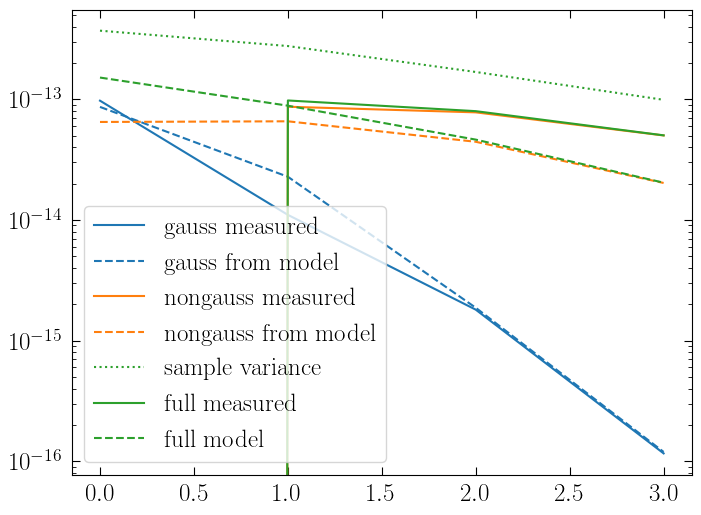

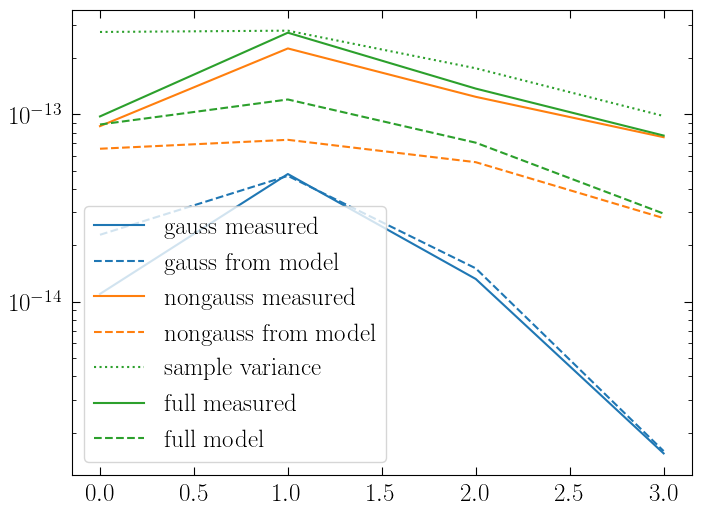

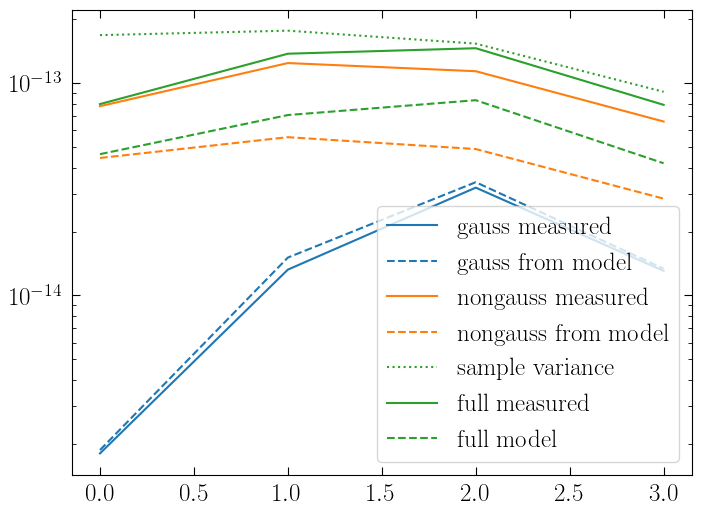

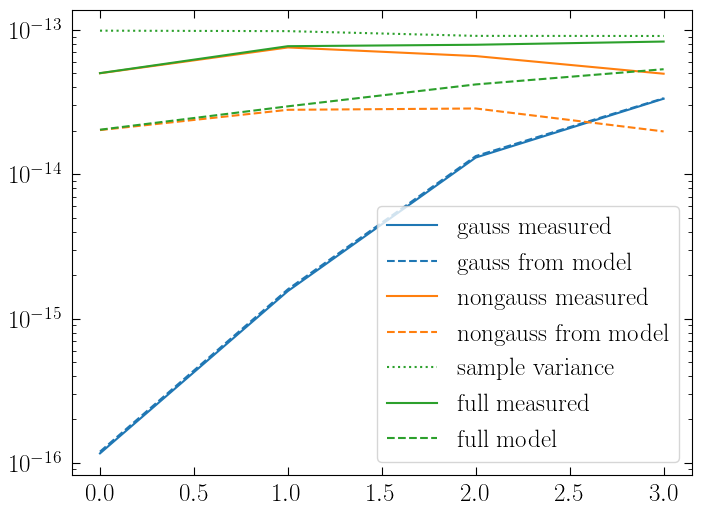

In [252]:
for i in range(4):
    plt.plot(map_map_covariance_gauss[i],color="C0",label=r'gauss measured')
    plt.plot(map_map_covariance_model_gauss[i],color="C0",linestyle='--',label='gauss from model')
    plt.plot(map_map_covariance_nongauss[i],color="C1",label=r'nongauss measured')
    plt.plot(map_map_covariance_model_nongauss[i],color="C1",linestyle='--',label='nongauss from model')
    plt.plot(cov_measured[i],color="C2",linestyle=':',label='sample variance')
    plt.plot(map_map_covariance_gauss[i]+map_map_covariance_nongauss[i],color="C2",label='full measured')
    plt.plot(map_map_covariance_model_gauss[i]+map_map_covariance_model_nongauss[i],linestyle='--',color="C2",label='full model')
    
    plt.plot()
    plt.yscale('log')
    plt.legend()
    plt.show()

In [253]:
np.savetxt("/vol/euclid6/euclid6_ssd/sven/threepoint_with_laila/Map2_Covariances/SLICS/T_gauss_for_map2.dat",map_map_covariance_gauss)
np.savetxt("/vol/euclid6/euclid6_ssd/sven/threepoint_with_laila/Map2_Covariances/SLICS/T_nongaussgauss_for_map2.dat",map_map_covariance_nongauss)

##  functions for Map3 covariance

In [179]:
def calculateT1(th1,th2,th3,th4,th5,th6,L):
    mysum = lambda eta: map_map_cubed(th1,th4,th2,th5,th3,th6,eta) \
                    +   map_map_cubed(th1,th4,th2,th6,th3,th5,eta) \
                    +   map_map_cubed(th1,th5,th2,th4,th3,th6,eta) \
                    +   map_map_cubed(th1,th5,th2,th6,th3,th4,eta) \
                    +   map_map_cubed(th1,th6,th2,th4,th3,th5,eta) \
                    +   map_map_cubed(th1,th6,th2,th5,th3,th4,eta) 

    integrand = lambda eta: eta*Efunction(eta,L)*mysum(eta)
#     print(map_correlation_function(100.))
#     result,err = quad(integrand,0,np.sqrt(2)*L)
    result = trapz(integrand(thetas_mean),thetas_mean)
    return 2*np.pi/(L*L)*result

def calculateT2(th1,th2,th3,th4,th5,th6,L):
    mysum = lambda eta: map_map_cubed_T2(th1,th2,th4,th5,th3,th6,eta) \
                        + map_map_cubed_T2(th1,th2,th4,th6,th3,th5,eta) \
                        + map_map_cubed_T2(th1,th2,th5,th6,th3,th4,eta) \
                        + map_map_cubed_T2(th1,th3,th4,th5,th2,th6,eta) \
                        + map_map_cubed_T2(th1,th3,th4,th6,th2,th5,eta) \
                        + map_map_cubed_T2(th1,th3,th5,th6,th2,th4,eta) \
                        + map_map_cubed_T2(th2,th3,th4,th5,th1,th6,eta) \
                        + map_map_cubed_T2(th2,th3,th4,th6,th1,th5,eta) \
                        + map_map_cubed_T2(th2,th3,th5,th6,th1,th4,eta)
    integrand = lambda eta: eta*Efunction(eta,L)*mysum(eta)
#     result,err = quad(integrand,0,np.sqrt(2)*L)
    result = trapz(integrand(thetas_mean),thetas_mean)
    return 2*np.pi/(L*L)*result

def calculateT5raw(th1,th2,th3,th4,th5,th6,L):
    mysum = lambda eta: map_map_mapsq_mapsq_T5(th1,th4,th2,th3,th5,th6,eta) \
                        + map_map_mapsq_mapsq_T5(th1,th5,th2,th3,th4,th6,eta) \
                        + map_map_mapsq_mapsq_T5(th1,th6,th2,th3,th4,th5,eta) \
                        + map_map_mapsq_mapsq_T5(th2,th4,th1,th3,th5,th6,eta) \
                        + map_map_mapsq_mapsq_T5(th2,th5,th1,th3,th4,th6,eta) \
                        + map_map_mapsq_mapsq_T5(th2,th6,th1,th3,th4,th5,eta) \
                        + map_map_mapsq_mapsq_T5(th3,th4,th1,th2,th5,th6,eta) \
                        + map_map_mapsq_mapsq_T5(th3,th5,th1,th2,th4,th6,eta) \
                        + map_map_mapsq_mapsq_T5(th3,th6,th1,th2,th4,th5,eta)
    integrand = lambda eta: eta*Efunction(eta,L)*mysum(eta)
#     result,err = quad(integrand,0,np.sqrt(2)*L)
    result = trapz(integrand(thetas_mean),thetas_mean)
    return 2*np.pi/(L*L)*result


def calculateT6raw(th1,th2,th3,th4,th5,th6,L):
    mysum = lambda eta: map_map_map_mapcu_T6(th1,th2,th3,th4,th5,th6,eta) \
                        + map_map_map_mapcu_T6(th1,th3,th2,th4,th5,th6,eta) \
                        + map_map_map_mapcu_T6(th2,th3,th1,th4,th5,th6,eta) \
                        + map_map_map_mapcu_T6(th4,th5,th6,th1,th2,th3,eta) \
                        + map_map_map_mapcu_T6(th4,th6,th5,th1,th2,th3,eta) \
                        + map_map_map_mapcu_T6(th5,th6,th4,th1,th2,th3,eta) 
    integrand = lambda eta: eta*Efunction(eta,L)*mysum(eta)
#     result,err = quad(integrand,0,np.sqrt(2)*L)
    result = trapz(integrand(thetas_mean),thetas_mean)
    return 2*np.pi/(L*L)*result


def calculateT4(th1,th2,th3,th4,th5,th6,L):
    mysum = lambda eta: get_mapsq_map_function(th1,th2,th4)(eta)*get_mapsq_map_function(th5,th6,th3)(eta) \
                    + get_mapsq_map_function(th1,th2,th5)(eta)*get_mapsq_map_function(th4,th6,th3)(eta) \
                    + get_mapsq_map_function(th1,th2,th6)(eta)*get_mapsq_map_function(th4,th5,th3)(eta) \
                    + get_mapsq_map_function(th1,th3,th4)(eta)*get_mapsq_map_function(th5,th6,th2)(eta) \
                    + get_mapsq_map_function(th1,th3,th5)(eta)*get_mapsq_map_function(th4,th6,th2)(eta) \
                    + get_mapsq_map_function(th1,th3,th6)(eta)*get_mapsq_map_function(th4,th5,th2)(eta) \
                    + get_mapsq_map_function(th4,th5,th1)(eta)*get_mapsq_map_function(th2,th3,th6)(eta) \
                    + get_mapsq_map_function(th4,th6,th1)(eta)*get_mapsq_map_function(th2,th3,th5)(eta) \
                    + get_mapsq_map_function(th5,th6,th1)(eta)*get_mapsq_map_function(th2,th3,th4)(eta)
                    
                    
    integrand = lambda eta: eta*Efunction(eta,L)*mysum(eta)
#     result,err = quad(integrand,0,np.sqrt(2)*L)
    result = trapz(integrand(thetas_mean),thetas_mean)
    return 2*np.pi/(L*L)*result

def calculateT7(th1,th2,th3,th4,th5,th6,L):
    integrand = lambda eta: eta*Efunction(eta,L)*get_mapcu_mapcu_function(th1,th2,th3,th4,th5,th6)(eta)
#     result,err = quad(integrand,0,np.sqrt(2)*L)
    result = trapz(integrand(thetas_mean),thetas_mean)
    return 2*np.pi/(L*L)*result


In [180]:
map_cubed_flat = np.zeros((map_cubed.shape[0],20))
counter = 0
for i in range(4):
    for j in range(i,4):
        for k in range(j,4):
            map_cubed_flat[:,counter] = map_cubed[:,i,j,k]
            counter += 1

In [181]:
model = {}

model["T2"] = np.loadtxt("/vol/euclid6/euclid6_ssd/sven/threepoint_with_laila/Map3_Covariances/SLICS_singleZ/cov_square_term2Numerical_sigma_0.00_n_107987.71_thetaMax_7.87_gpu.dat")
model["T6"] = np.loadtxt("/vol/euclid6/euclid6_ssd/sven/threepoint_with_laila/Map3_Covariances/SLICS_singleZ/cov_square_term6Numerical_sigma_0.00_n_107987.71_thetaMax_7.87_gpu.dat")
model["T1"] = np.loadtxt("/vol/euclid6/euclid6_ssd/sven/threepoint_with_laila/Map3_Covariances/SLICS_singleZ/cov_infinite_term1Numerical_sigma_0.00_n_107987.71_thetaMax_7.87_gpu.dat")
model["T5"] = np.loadtxt("/vol/euclid6/euclid6_ssd/sven/threepoint_with_laila/Map3_Covariances/SLICS_singleZ/cov_infinite_term5Numerical_sigma_0.00_n_107987.71_thetaMax_7.87_gpu.dat")
model["T4"] = np.loadtxt("/vol/euclid6/euclid6_ssd/sven/threepoint_with_laila/Map3_Covariances/SLICS_singleZ/cov_infinite_term4Numerical_sigma_0.00_n_107987.71_thetaMax_7.87_gpu.dat")
model["T7"] = np.loadtxt("/vol/euclid6/euclid6_ssd/sven/threepoint_with_laila/Map3_Covariances/SLICS_singleZ/cov_infinite_term7Numerical_sigma_0.00_n_107987.71_thetaMax_7.87_gpu.dat")
# model["T6"] = np.zeros((20,20))

direct_measured = {}
direct_measured["cov"] = np.cov(map_cubed_flat,rowvar=False)
direct_measured["data"] = np.mean(map_cubed_flat,axis=0)


In [182]:
T1_sims = np.zeros((20,20))
T2_sims = np.zeros((20,20))
T4_sims = np.zeros((20,20))
T5raw_sims = np.zeros((20,20))
T6raw_sims = np.zeros((20,20))
allT_sims = np.zeros((20,20))
L = (10*60-8*16)/60/180*np.pi
idx = -1
for i in range(n_theta_ap):
    for j in range(i,n_theta_ap):
        for k in range(j,n_theta_ap):
            idy = -1
            idx += 1
            for ii in range(n_theta_ap):
                for jj in range(ii,n_theta_ap):
                    for kk in range(jj,n_theta_ap):
                        idy += 1
                        T1_sims[idx,idy] = calculateT1(all_theta_ap[i],all_theta_ap[j],all_theta_ap[k],
                                                      all_theta_ap[ii],all_theta_ap[jj],all_theta_ap[kk],L)
                        T2_sims[idx,idy] = calculateT2(all_theta_ap[i],all_theta_ap[j],all_theta_ap[k],
                              all_theta_ap[ii],all_theta_ap[jj],all_theta_ap[kk],L)
                        T4_sims[idx,idy] = calculateT4(all_theta_ap[i],all_theta_ap[j],all_theta_ap[k],
                              all_theta_ap[ii],all_theta_ap[jj],all_theta_ap[kk],L)
                        T5raw_sims[idx,idy] = calculateT5raw(all_theta_ap[i],all_theta_ap[j],all_theta_ap[k],
                              all_theta_ap[ii],all_theta_ap[jj],all_theta_ap[kk],L)
                        T6raw_sims[idx,idy] = calculateT6raw(all_theta_ap[i],all_theta_ap[j],all_theta_ap[k],
                              all_theta_ap[ii],all_theta_ap[jj],all_theta_ap[kk],L)
                        allT_sims[idx,idy] = calculateT7(all_theta_ap[i],all_theta_ap[j],all_theta_ap[k],
                              all_theta_ap[ii],all_theta_ap[jj],all_theta_ap[kk],L)
                        progressBar("Calculating Ti",idx*20+idy,400)

                        

T5_sims = T5raw_sims - 3*T1_sims - T2_sims
T6_sims = T6raw_sims - 2*T2_sims

measured_corrf = {}
measured_corrf["T1"] = T1_sims
measured_corrf["T2"] = T2_sims
measured_corrf["T4"] = T4_sims
measured_corrf["T5"] = T5_sims
measured_corrf["T6"] = T6_sims
measured_corrf["T7"] = allT_sims - T1_sims - T2_sims - np.outer(direct_measured["data"],direct_measured["data"]) - T4_sims - T5_sims - T6_sims

Calculating Ti       : [------------------------>]100%

In [183]:
direct_measured["data"]

array([7.91570685e-08, 5.07470770e-08, 2.45153821e-08, 1.09549628e-08,
       3.28707845e-08, 1.50688457e-08, 6.53052613e-09, 5.33308888e-09,
       1.88860400e-09, 4.72091432e-10, 3.24811169e-08, 1.88068817e-08,
       8.99661246e-09, 1.07180149e-08, 4.71042922e-09, 1.50896082e-09,
       9.71644899e-09, 5.47377090e-09, 2.96494689e-09, 2.63625210e-09])

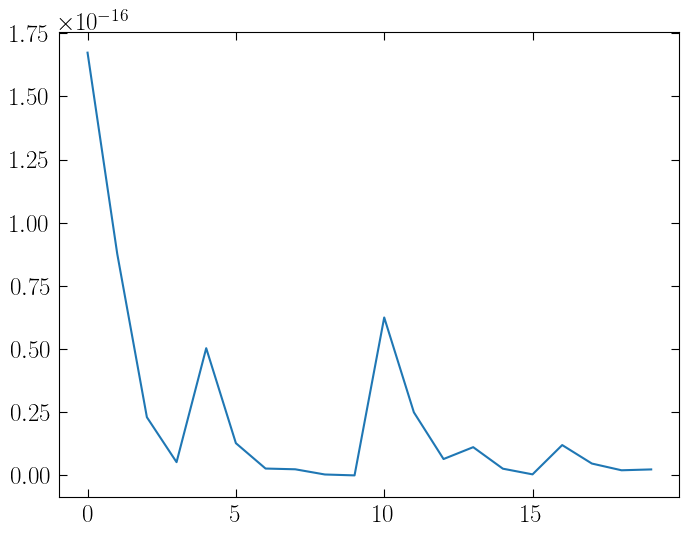

In [184]:
plt.plot(np.diag(allT_sims)-(direct_measured["data"])**2)
# plt.yscale('log')

In [185]:
for i in [1,2,4,5,6,7]:
    np.savetxt("/vol/euclid6/euclid6_ssd/sven/threepoint_with_laila/Map3_Covariances/Ti_from_SLICS/T_{}_measured_singlez.dat".format(i),
              measured_corrf["T{}".format(i)])

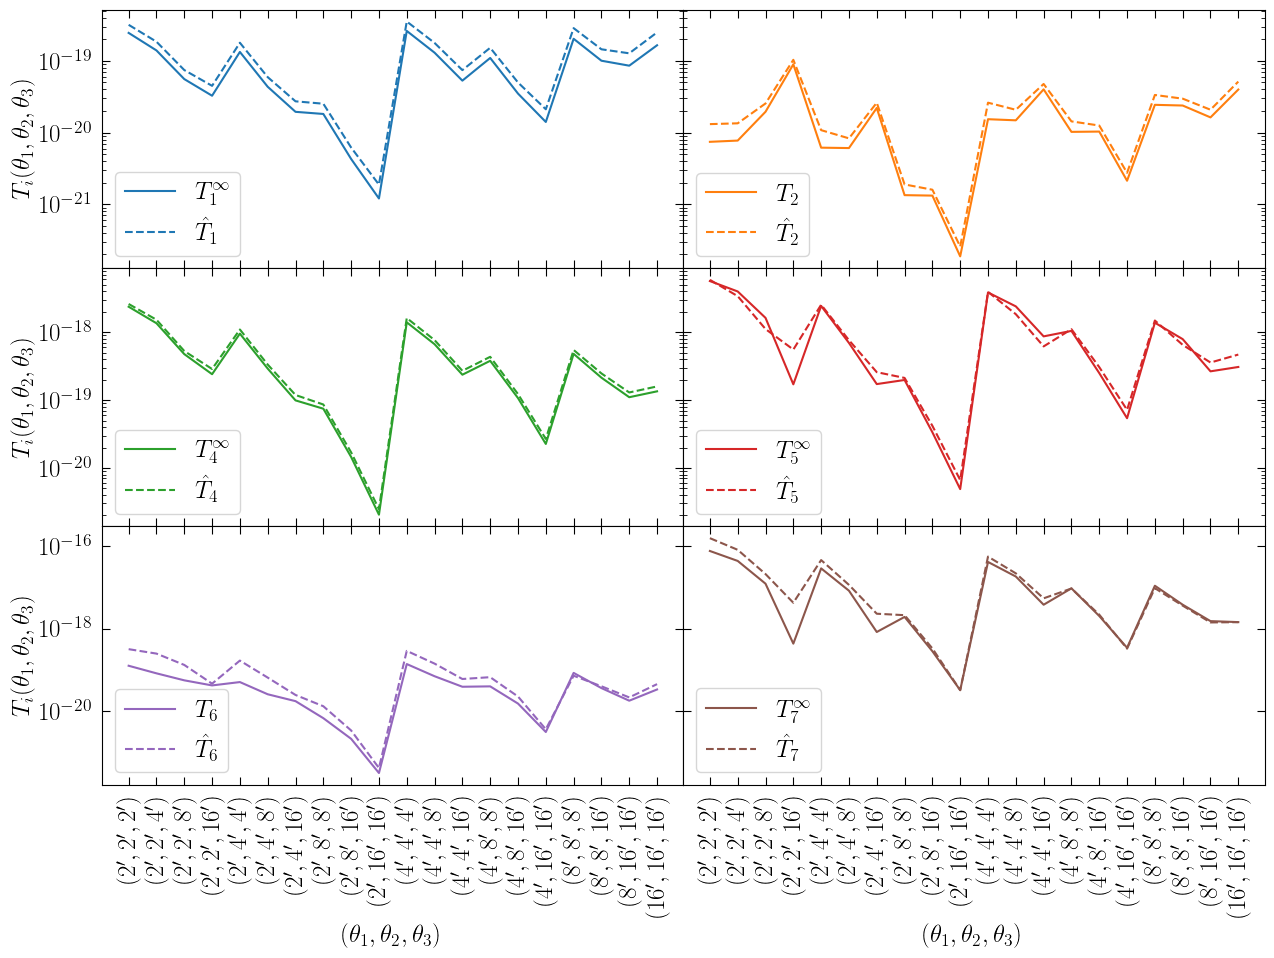

In [188]:
fig,ax = plt.subplots(3,2,figsize=(15,10),sharex=True,sharey="row")
plt.subplots_adjust(wspace=0,hspace=0)
for c,i in enumerate([1,2,4,5,6,7]):
    ax2 = c%2
    ax1 = c//2
    if i in [1,4,5,7]:
        inf = r"^\infty"
    else:
        inf = ""
    ax[ax1,ax2].plot(np.diag(model["T{}".format(i)]),color="C{}".format(c),label = r"$T_{}{}$".format(i,inf))
    ax[ax1,ax2].plot(np.diag(measured_corrf["T{}".format(i)]),color="C{}".format(c),label=r"$\hat{T}"+"_{}$".format(i),
            linestyle="--")
    ax[ax1,ax2].set_yscale('log')
    ax[ax1,ax2].legend(loc="lower left")
#     ax[ax1,ax2].set_xscale('log')

#     ax[2,1].plot([],color="C{}".format(c),label = r"$T_{}$".format(i))
#     ax[2,1].plot([],color="C{}".format(c),label=r"$\hat{T}"+"_{}$".format(i),
#             linestyle="--")
#     ax[2,1].plot((direct_measured["data"])**2,color='red',linestyle=':')
#     ax[2,1].plot(np.diag(allT_sims),color='purple',linestyle=':')


# ax[2,1].legend(loc="lower right",ncol=6,bbox_to_anchor=(1,-0.75))
for i in range(3):
    ax[i,0].set_ylabel(r"$T_i(\theta_1,\theta_2,\theta_3)$")
ax[2,0].set_xlabel(r"$(\theta_1,\theta_2,\theta_3)$")
ax[2,1].set_xlabel(r"$(\theta_1,\theta_2,\theta_3)$")
ax[2,0].set_xticks(np.arange(20))
ax[2,0].set_xticklabels(get_theta_combinations([2,4,8,16]),rotation=90)
ax[2,1].set_xticks(np.arange(20))
ax[2,1].set_xticklabels(get_theta_combinations([2,4,8,16]),rotation=90)


# plt.savefig("/users/sven/Sciebo/tex_files/thesis/phd_thesis/figures/ti_for_SLICS_singlez.png",dpi=200,
#            bbox_inches="tight")
plt.show()

# for c,i in enumerate([7]):
# #     plt.plot(np.diag(model["T{}".format(i)])*10**6,color="C{}".format(c+5),label = r"$10^6\times T_{}$ model".format(i))
#     plt.plot(np.diag(measured_corrf["T{}".format(i)]),color="C{}".format(c+5),label=r"$T_{}$ measured".format(i),
#             linestyle="--")
#     plt.plot(np.diag(direct_measured["cov"]-T1_sims-T2_sims-T4_sims-T5_sims-T6_sims), color="C{}".format(c+5),
#             label=r"$T_{}$ from covariance".format(i),linestyle=':')
# plt.yscale('log')
# # plt.ylim(10**-19,10**-15)
# plt.legend(loc="lower right",bbox_to_anchor=(1.2,0))
# plt.show()


In [74]:
def standfracstr(s1,s2):
    x = s1+"-"+s2
    y = r"\sqrt{"+s1+"^2+"+s2+"^2}"
    return r"$\frac{"+x+"}{"+y+"}$"

/users/sven/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

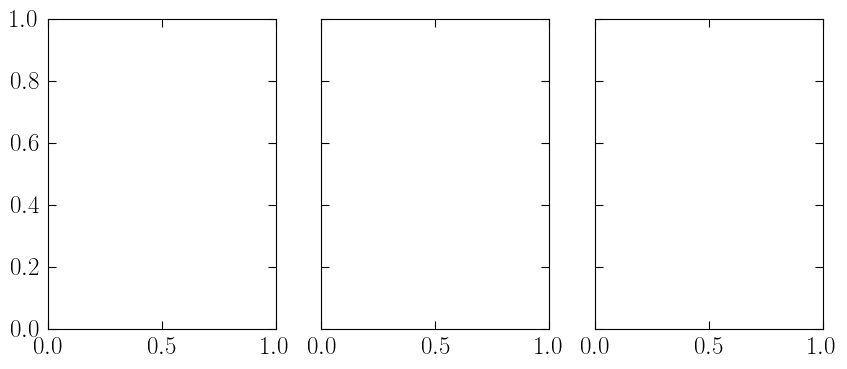

In [41]:
fig,ax = plt.subplots(1,3,sharex=True,sharey=True,figsize=(10,4))
covsample = direct_measured["cov"]
covtiest = allT_sims-np.outer(direct_measured["data"],direct_measured["data"])
covti = model["T1"]+model["T2"]+model["T4"]+model["T5"]+model["T6"]+model["T7"]
allmax = np.max([covsample,covtiest,covti])
allmin = np.max([np.min([covsample,covtiest,covti]),10**-21])
im=ax[0].imshow(covsample,norm=colors.LogNorm(vmin=allmin,vmax=allmax))
im=ax[1].imshow(covtiest,norm=colors.LogNorm(vmin=allmin,vmax=allmax))
im=ax[2].imshow(covti,norm=colors.LogNorm(vmin=allmin,vmax=allmax))
c1 = r"C_{\mathrm{sample}}"
c2 = r"\big(\sum_{i\neq 3}\hat{T}_i\big)"
c3 = r"\big(\sum_{i\neq 3} T_i\big)"
ax[0].set_title(r"${}$".format(c1))
ax[1].set_title(r"${}$".format(c2))
ax[2].set_title(r"${}$".format(c3))

for i in range(3):
    ax[i].set_yticks(np.arange(20))
    ax[i].set_yticklabels(get_theta_combinations([2,4,8,16]),fontsize=9)

    ax[i].set_xticks(np.arange(20))
    ax[i].set_xticklabels(get_theta_combinations([2,4,8,16]),fontsize=9,rotation=90)

plt.tight_layout()

fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.9, 0.18, 0.03, 0.63])
fig.colorbar(im, cax=cbar_ax)

plt.savefig("/users/sven/Sciebo/tex_files/thesis/phd_thesis/figures/cov_ti_tiest_sample_slics_singlez.png",
           dpi=200)
plt.show()



fig,ax = plt.subplots(1,3,sharex=True,sharey=True,figsize=(10,4))

ratio1=(covsample-covti)/np.sqrt(covsample**2+covti**2)
ratio2=(covtiest-covti)/np.sqrt(covtiest**2+covti**2)
ratio3=(covsample-covtiest)/np.sqrt(covsample**2+covtiest**2)
allmax = np.max(np.abs([ratio1,ratio2,ratio3]))

im2 = ax[0].imshow(ratio1,cmap='seismic',vmin=-allmax,vmax=allmax)
im2 = ax[1].imshow(ratio2,cmap='seismic',vmin=-allmax,vmax=allmax)
im2 = ax[2].imshow(ratio3,cmap='seismic',vmin=-allmax,vmax=allmax)

ax[0].set_title(standfracstr(c1,c3))
ax[1].set_title(standfracstr(c2,c3))
ax[2].set_title(standfracstr(c1,c2))

for i in range(3):
    ax[i].set_yticks(np.arange(20))
    ax[i].set_yticklabels(get_theta_combinations([2,4,8,16]),fontsize=9)

    ax[i].set_xticks(np.arange(20))
    ax[i].set_xticklabels(get_theta_combinations([2,4,8,16]),fontsize=9,rotation=90)


plt.tight_layout()

fig.subplots_adjust(right=0.85)

cbar_ax2 = fig.add_axes([0.9, 0.15, 0.03, 0.62])

fig.colorbar(im2, cax=cbar_ax2)

plt.savefig("/users/sven/Sciebo/tex_files/thesis/phd_thesis/figures/cov_ti_tiest_sample_ratio_slics_singlez.png",
           dpi=200)

In [ ]:
plt.plot(np.diag(direct_measured["cov"]),label='sample variance')
plt.plot(np.diag(allT_sims-direct_measured["data"]**2),label=r"$\sum T_i - T_3$")
plt.yscale('log')
plt.legend()

In [187]:
def get_theta_combinations(theta_ap,return_str=True):
    n_ap = len(theta_ap)
    aperture_radii = []
    for i in range(n_ap):
        for j in range(i,n_ap):
            for k in range(j,n_ap):
                if return_str:
                    aperture_radii.append(r"$({}',{}',{}')$".format(theta_ap[i],theta_ap[j],theta_ap[k]))
    return aperture_radii

["$(2',2',2')$",
 "$(2',2',4')$",
 "$(2',2',8')$",
 "$(2',2',16')$",
 "$(2',4',4')$",
 "$(2',4',8')$",
 "$(2',4',16')$",
 "$(2',8',8')$",
 "$(2',8',16')$",
 "$(2',16',16')$",
 "$(4',4',4')$",
 "$(4',4',8')$",
 "$(4',4',16')$",
 "$(4',8',8')$",
 "$(4',8',16')$",
 "$(4',16',16')$",
 "$(8',8',8')$",
 "$(8',8',16')$",
 "$(8',16',16')$",
 "$(16',16',16')$"]